# Boundary mapping

The purpose of this notebook is to mess around with all the different options available with boundary mapping

In [27]:
import os
import sys
from typing import Tuple
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import database, gen_spectra
import testing_utils

from scoring import mass_comparisons
from constants import WATER_MASS, SINGLY_CHARGED_B_BASE, SINGLY_CHARGED_Y_BASE
from utils import ppm_to_da, overlap_intervals, hashable_boundaries
from preprocessing import merge_search, preprocessing_utils
from collections import defaultdict
from objects import Spectrum

#Assumptions:
max_peptide_length = 20
ppm_tolerance = 20

import matplotlib.pyplot as plt

In [28]:
datasets = testing_utils.define_data()

dataset = datasets[0]

input_spectra_path = dataset[0]
input_spectra, boundaries, mz_mapping = testing_utils.preprocess_input_spectra(input_spectra_path, ppm_tolerance)

correct_sequences = testing_utils.generate_truth_set(datasets[0])

path = dataset[2]
db = database.build(path)

Loading spectra...
Done


In [29]:
matched_masses_b, matched_masses_y, db = testing_utils.modified_match_masses(boundaries, db, max_peptide_length)
print('Finished matching masses')

with open('matched_masses_b.txt', 'w') as m:
    [m.write(str(x) + '\n') for x in matched_masses_b]

On batch 1/1
On protein 279/279 [100%]
Sorting the set of protein masses...
Done
Finished matching masses


# Grabbing hits

In [30]:
print('Grabbing hits...')
spectrum_num = 0
correct_sequence = correct_sequences[spectrum_num]
print(correct_sequence)

input_spectrum = input_spectra[spectrum_num]
print(input_spectrum.mz_values)
print(mz_mapping[input_spectrum.mz_values[7]])
print(boundaries[93])
b = hashable_boundaries(boundaries[93])
print(b)

correct_hits = []
#Remember to add in abundance if it is helpful
input_num = 0
b_hits, y_hits, b_set, y_set, misses = testing_utils.find_hits(mz_mapping, boundaries, input_spectrum, input_num, matched_masses_b, matched_masses_y)
# testing_utils.append_correct_hits(correct_hits, correct_sequence, input_spectrum, ppm_tolerance)
print('Done')

Grabbing hits...
DPQVEQLEL
[70.06548309326172, 84.04374694824219, 84.0806655883789, 86.09642028808594, 101.07074737548828, 102.05448913574219, 129.1007537841797, 132.10121154785156, 225.12210083007812, 226.1183624267578, 235.1075439453125, 243.13357543945312, 261.1429443359375, 341.1453857421875, 349.1622619628906, 358.1739196777344, 412.21746826171875, 440.216064453125, 569.2589721679688, 586.2818603515625, 697.3143310546875, 698.3234252929688, 810.3919677734375, 811.4014892578125, 939.4456176757812]
93
[132.0970741921997, 132.10629502716066]
132.0970741921997-132.10629502716066
Done


# Writing hits

In [31]:
#Writing b and y hits
print('Writing data...')
with open("b_hits.txt", 'w') as b:
    for x in b_hits:
        pep_id = x[0]
        w = x[1]
        prot_id = x[2][1]
        seq = x[2][2]
        loc = x[2][3]
        ion = x[2][4]
        charge = x[2][5]
        out = [pep_id, w, prot_id, seq, loc, ion, charge]
        b.write('\t'.join([str(i) for i in out]) + '\n')
with open("y_hits.txt", 'w') as y_file:
    for y in y_hits:
        pep_id = y[0]
        w = y[1]
        prot_id = y[2][1]
        seq = y[2][2]
        loc = y[2][3]
        ion = y[2][4]
        charge = y[2][5]
        out = [pep_id, w, prot_id, seq, loc, ion, charge]
        y_file.write('\t'.join([str(i) for i in out]) + '\n')
print('Done')

Writing data...
Done


# Clustering b hits

In [32]:
# b_hits

import collections
import operator

Hit = collections.namedtuple('Hit', 'pid start end seq mz')

def write_cluster(cluster):
    if len(cluster) == 0 : return None
    O = []

    O.append(len(cluster))
    O.append(cluster[0].pid)

    max_len = 0
    max_hit = None

    for hit in cluster:
        l = hit.end - hit.start + 1
        if l > max_len:
            max_len = l
            max_hit = hit

    O.append(max_hit.seq)
    O.append(max_hit.mz)
    
    for hit in cluster:
        O.append( (hit.start, hit.end, hit.seq, hit.mz) )
    
#     print( '\t'.join( [str(o) for o in O] ) )
    with open('clusters.txt', 'a') as c:
        c.write( '\t'.join( [str(o) for o in O] ) )
        c.write('\n')




file_name = 'b_hits.txt'
ion = 'b'
# file_name = sys.argv[1]

hits = []

for l in open(file_name):
    A = l.rstrip().split('\t')
    pid = int(A[2])
    start = int(A[4].split('-')[0])
    end = int(A[4].split('-')[1])
    seq = A[3]
    mz = A[1]

    hits.append( Hit(pid=pid, start=start, end=end, seq=seq, mz=mz) )

sorted_hits = sorted(hits, key=operator.attrgetter('pid', 'start', 'end'))

last_pid = None
last_start = None

cluster = []

with open('clusters.txt', 'w') as c:
    c.write('')

if ion == 'b':
    for hit in sorted_hits:
        if last_pid == hit.pid and last_start == hit.start:
            cluster.append(hit)
        else:
            write_cluster(cluster)
            cluster = [hit]
        last_pid = hit.pid
        last_start = hit.start

# Printing data

In [33]:
def set_prior(mz, ion):
    # for i in range (0, len(b_sorted_clusters)):
    # prior = 1 / # of occurances
    mapped = mz_mapping[mz]
    b = boundaries[mapped]
    b = hashable_boundaries(b)
    if ion == 'b':
        if len(matched_masses_b[b]) == 0:
            print(mz)
            print(mapped)
            print(b)
            with open('mz_mapping.txt', 'w') as m:
                [m.write(str(x) + '\n') for x in mz_mapping]
        P_A = 1/len(matched_masses_b[b]) # if (len(matched_masses_b[b]) !=0) else 1
    else:
        if len(matched_masses_y[b]) == 0:
            print(mz)
            print(mapped)
            print(b)
            with open('mz_mapping.txt', 'w') as m:
                [m.write(str(x) + '\n') for x in mz_mapping]
        P_A = 1/len(matched_masses_y[b]) # if (len(matched_masses_b[b]) !=0) else 1
    
    return P_A
def calc_post_prob(prior, indices):
    post = 0
    current_prob = prior
    for element in indices:
        A = element.rstrip().split(',')
        string = A[2]
#         mz = (A[3])
#         mz = mz[:-1]
#         mz = mz[2:]
        post = post + 1/len(string) + prior
    return post


In [35]:
cluster = collections.namedtuple('cluster', 'post_prob prior score addscore pid seq mz indices')
# b_hits
b_cluster_array = []
with open('clusters.txt', 'r') as c:
    for line in c:
        A = line.rstrip().split('\t')
        score = int(A[0])
        pid = int(A[1])
        seq = A[2]
        mz = float(A[3])
        indices = []
        [indices.append(A[x]) for x in range(4,len(A))]
        prior = set_prior(mz, 'b')
        post_prob = calc_post_prob(prior, indices)
        addscore = mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(seq, ion='b'))

        b_cluster_array.append(cluster(post_prob=post_prob, prior=prior, score=score, addscore=addscore, pid=pid, seq=seq, mz=mz, indices=indices) )

b_sorted_clusters = sorted(b_cluster_array, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
for cluster in b_sorted_clusters:
    non_indices = str(cluster.score) + '\t' + str(cluster.post_prob) + '\t' + str(cluster.addscore) + '\t' + str(cluster.pid) + '\t' + cluster.seq + '\t' + str(cluster.mz)
    print((non_indices) + '\t'+ '\t'.join([str(o) for o in cluster.indices]))


7	0.8524927176793105	7	274	DPQVEQLE	939.4456176757812	(60, 62, 'DPQ', '341.1453857421875')	(60, 63, 'DPQV', '440.216064453125')	(60, 64, 'DPQVE', '569.2589721679688')	(60, 65, 'DPQVEQ', '349.1622619628906')	(60, 65, 'DPQVEQ', '697.3143310546875')	(60, 66, 'DPQVEQL', '810.3919677734375')	(60, 67, 'DPQVEQLE', '939.4456176757812')
5	0.8110311825930346	2	152	KNDIPKDK	939.4456176757812	(78, 78, 'K', '129.1007537841797')	(78, 79, 'KN', '243.13357543945312')	(78, 80, 'KND', '358.1739196777344')	(78, 84, 'KNDIPKD', '811.4014892578125')	(78, 85, 'KNDIPKDK', '939.4456176757812')
4	0.6882286336097876	1	188	KNGNAT	586.2818603515625	(194, 194, 'K', '129.1007537841797')	(194, 195, 'KN', '243.13357543945312')	(194, 198, 'KNGNA', '243.13357543945312')	(194, 199, 'KNGNAT', '586.2818603515625')
4	0.6882286336097876	1	105	KNGNAT	586.2818603515625	(197, 197, 'K', '129.1007537841797')	(197, 198, 'KN', '243.13357543945312')	(197, 201, 'KNGNA', '243.13357543945312')	(197, 202, 'KNGNAT', '586.2818603515625')


2	0.4505253480430786	1	13	KN	243.13357543945312	(851, 851, 'K', '129.1007537841797')	(851, 852, 'KN', '243.13357543945312')
2	0.4505253480430786	1	11	KN	243.13357543945312	(636, 636, 'K', '129.1007537841797')	(636, 637, 'KN', '243.13357543945312')
2	0.4505253480430786	1	7	KN	243.13357543945312	(50, 50, 'K', '129.1007537841797')	(50, 51, 'KN', '243.13357543945312')
2	0.4505253480430786	1	6	KN	243.13357543945312	(120, 120, 'K', '129.1007537841797')	(120, 121, 'KN', '243.13357543945312')
2	0.4505253480430786	1	6	KN	243.13357543945312	(171, 171, 'K', '129.1007537841797')	(171, 172, 'KN', '243.13357543945312')
2	0.4505253480430786	1	5	KN	243.13357543945312	(140, 140, 'K', '129.1007537841797')	(140, 141, 'KN', '243.13357543945312')
2	0.4505253480430786	1	1	KN	243.13357543945312	(50, 50, 'K', '129.1007537841797')	(50, 51, 'KN', '243.13357543945312')
2	0.4505253480430786	1	1	KN	243.13357543945312	(110, 110, 'K', '129.1007537841797')	(110, 111, 'KN', '243.13357543945312')
2	0.4505253480430786	1

2	0.4503583587170758	2	85	TT	102.05448913574219	(1307, 1307, 'T', '102.05448913574219')	(1307, 1308, 'TT', '102.05448913574219')
2	0.4503583587170758	2	84	TT	102.05448913574219	(240, 240, 'T', '102.05448913574219')	(240, 241, 'TT', '102.05448913574219')
2	0.4503583587170758	2	81	TT	102.05448913574219	(172, 172, 'T', '102.05448913574219')	(172, 173, 'TT', '102.05448913574219')
2	0.4503583587170758	2	80	TT	102.05448913574219	(29, 29, 'T', '102.05448913574219')	(29, 30, 'TT', '102.05448913574219')
2	0.4503583587170758	2	78	TT	102.05448913574219	(18, 18, 'T', '102.05448913574219')	(18, 19, 'TT', '102.05448913574219')
2	0.4503583587170758	2	78	TT	102.05448913574219	(48, 48, 'T', '102.05448913574219')	(48, 49, 'TT', '102.05448913574219')
2	0.4503583587170758	2	78	TT	102.05448913574219	(152, 152, 'T', '102.05448913574219')	(152, 153, 'TT', '102.05448913574219')
2	0.4503583587170758	2	76	TT	102.05448913574219	(1041, 1041, 'T', '102.05448913574219')	(1041, 1042, 'TT', '102.05448913574219')
2	0.

2	0.4502785127419579	2	129	KK	129.1007537841797	(33, 33, 'K', '129.1007537841797')	(33, 34, 'KK', '129.1007537841797')
2	0.4502785127419579	2	129	KK	129.1007537841797	(483, 483, 'K', '129.1007537841797')	(483, 484, 'KK', '129.1007537841797')
2	0.4502785127419579	2	129	KK	129.1007537841797	(644, 644, 'K', '129.1007537841797')	(644, 645, 'KK', '129.1007537841797')
2	0.4502785127419579	2	129	KK	129.1007537841797	(833, 833, 'K', '129.1007537841797')	(833, 834, 'KK', '129.1007537841797')
2	0.4502785127419579	2	129	KK	129.1007537841797	(834, 834, 'K', '129.1007537841797')	(834, 835, 'KK', '129.1007537841797')
2	0.4502785127419579	2	129	KK	129.1007537841797	(968, 968, 'K', '129.1007537841797')	(968, 969, 'KK', '129.1007537841797')
2	0.4502785127419579	2	129	KK	129.1007537841797	(1014, 1014, 'K', '129.1007537841797')	(1014, 1015, 'KK', '129.1007537841797')
2	0.4502785127419579	2	129	KK	129.1007537841797	(1042, 1042, 'K', '129.1007537841797')	(1042, 1043, 'KK', '129.1007537841797')
2	0.45027851

2	0.4174451797067601	1	265	TQK	358.1739196777344	(9, 9, 'T', '102.05448913574219')	(9, 11, 'TQK', '358.1739196777344')
2	0.4174451797067601	1	245	TKQ	358.1739196777344	(449, 449, 'T', '102.05448913574219')	(449, 451, 'TKQ', '358.1739196777344')
2	0.4174451797067601	2	240	KDN	358.1739196777344	(562, 562, 'K', '129.1007537841797')	(562, 564, 'KDN', '358.1739196777344')
2	0.4174451797067601	1	232	TQK	358.1739196777344	(56, 56, 'T', '102.05448913574219')	(56, 58, 'TQK', '358.1739196777344')
2	0.4174451797067601	1	232	TKQ	358.1739196777344	(322, 322, 'T', '102.05448913574219')	(322, 324, 'TKQ', '358.1739196777344')
2	0.4174451797067601	1	229	TKQ	358.1739196777344	(259, 259, 'T', '102.05448913574219')	(259, 261, 'TKQ', '358.1739196777344')
2	0.4174451797067601	1	224	TQK	358.1739196777344	(215, 215, 'T', '102.05448913574219')	(215, 217, 'TQK', '358.1739196777344')
2	0.4174451797067601	2	217	KDN	358.1739196777344	(281, 281, 'K', '129.1007537841797')	(281, 283, 'KDN', '358.1739196777344')
2	0.4

2	0.3718480138169258	2	40	PQD	341.1453857421875	(105, 106, 'PQ', '226.1183624267578')	(105, 107, 'PQD', '341.1453857421875')
2	0.3718480138169258	2	27	QPD	341.1453857421875	(173, 174, 'QP', '226.1183624267578')	(173, 175, 'QPD', '341.1453857421875')
2	0.3718480138169258	2	5	QPD	341.1453857421875	(21, 22, 'QP', '226.1183624267578')	(21, 23, 'QPD', '341.1453857421875')
2	0.37162944582299423	1	273	YAN	349.1622619628906	(296, 297, 'YA', '235.1075439453125')	(296, 298, 'YAN', '349.1622619628906')
2	0.37162944582299423	1	269	AYN	349.1622619628906	(60, 61, 'AY', '235.1075439453125')	(60, 62, 'AYN', '349.1622619628906')
2	0.37162944582299423	1	265	FSN	349.1622619628906	(3, 4, 'FS', '235.1075439453125')	(3, 5, 'FSN', '349.1622619628906')
2	0.37162944582299423	1	255	HPN	349.1622619628906	(76, 77, 'HP', '235.1075439453125')	(76, 78, 'HPN', '349.1622619628906')
2	0.37162944582299423	1	254	SFN	349.1622619628906	(662, 663, 'SF', '235.1075439453125')	(662, 664, 'SFN', '349.1622619628906')
2	0.3716294

2	0.36216987236044934	2	141	TNTTAP	586.2818603515625	(326, 326, 'T', '102.05448913574219')	(326, 331, 'TNTTAP', '586.2818603515625')
2	0.36216987236044934	2	138	KPGSDT	586.2818603515625	(178, 178, 'K', '129.1007537841797')	(178, 183, 'KPGSDT', '586.2818603515625')
2	0.36216987236044934	1	131	KVGTCP	586.2818603515625	(1113, 1113, 'K', '129.1007537841797')	(1113, 1118, 'KVGTCP', '586.2818603515625')
2	0.36216987236044934	1	127	TGPSSR	586.2818603515625	(792, 792, 'T', '102.05448913574219')	(792, 797, 'TGPSSR', '586.2818603515625')
2	0.36216987236044934	2	116	TDALNA	586.2818603515625	(422, 422, 'T', '102.05448913574219')	(422, 427, 'TDALNA', '586.2818603515625')
2	0.36216987236044934	1	116	KDPGMG	586.2818603515625	(554, 554, 'K', '129.1007537841797')	(554, 559, 'KDPGMG', '586.2818603515625')
2	0.36216987236044934	2	110	TVQAAD	586.2818603515625	(1151, 1151, 'T', '102.05448913574219')	(1151, 1156, 'TVQAAD', '586.2818603515625')
2	0.36216987236044934	1	85	KACEPG	586.2818603515625	(1535, 1535,

2	0.3347155033402442	1	186	KGIAGRQDI	939.4456176757812	(146, 146, 'K', '129.1007537841797')	(146, 154, 'KGIAGRQDI', '939.4456176757812')
2	0.3347155033402442	2	166	TQPQGTTQP	939.4456176757812	(1056, 1056, 'T', '102.05448913574219')	(1056, 1064, 'TQPQGTTQP', '939.4456176757812')
2	0.3347155033402442	1	162	TLPTPKTEA	939.4456176757812	(908, 908, 'T', '102.05448913574219')	(908, 916, 'TLPTPKTEA', '939.4456176757812')
2	0.3347155033402442	2	156	KEPAGENGR	939.4456176757812	(497, 497, 'K', '129.1007537841797')	(497, 505, 'KEPAGENGR', '939.4456176757812')
2	0.3347155033402442	1	149	KALHTCSPT	939.4456176757812	(399, 399, 'K', '129.1007537841797')	(399, 407, 'KALHTCSPT', '939.4456176757812')
2	0.3347155033402442	2	129	TPTPDSSPR	939.4456176757812	(1846, 1846, 'T', '102.05448913574219')	(1846, 1854, 'TPTPDSSPR', '939.4456176757812')
2	0.3347155033402442	1	116	TPEEIAQVA	939.4456176757812	(164, 164, 'T', '102.05448913574219')	(164, 172, 'TPEEIAQVA', '939.4456176757812')
2	0.3347155033402442	1	110	KL

2	0.3045752135440642	2	140	TEAEAVATEAPARPLN	811.4014892578125	(76, 76, 'T', '102.05448913574219')	(76, 91, 'TEAEAVATEAPARPLN', '811.4014892578125')
2	0.3045752135440642	1	137	TECKAIQGILHEIGGA	811.4014892578125	(1790, 1790, 'T', '102.05448913574219')	(1790, 1805, 'TECKAIQGILHEIGGA', '811.4014892578125')
2	0.3045752135440642	2	129	TSSSGAQALSKQKEMS	811.4014892578125	(1252, 1252, 'T', '102.05448913574219')	(1252, 1267, 'TSSSGAQALSKQKEMS', '811.4014892578125')
2	0.3045752135440642	1	61	KFGFAIGSQTARKASA	811.4014892578125	(70, 70, 'K', '129.1007537841797')	(70, 85, 'KFGFAIGSQTARKASA', '811.4014892578125')
2	0.3045752135440642	2	45	TAKVAGEGCVYLQTSL	811.4014892578125	(1313, 1313, 'T', '102.05448913574219')	(1313, 1328, 'TAKVAGEGCVYLQTSL', '811.4014892578125')
3	0.3040934570305683	2	265	SGRYYALK	939.4456176757812	(170, 175, 'SGRYYA', '698.3234252929688')	(170, 176, 'SGRYYAL', '811.4014892578125')	(170, 177, 'SGRYYALK', '939.4456176757812')
2	0.3040137489542793	1	275	KVDVFREDLCSKTENL	939.44561767

2	0.26891590410648114	0	233	QREAT	586.2818603515625	(481, 484, 'QREA', '243.13357543945312')	(481, 485, 'QREAT', '586.2818603515625')
2	0.26891590410648114	0	212	EAKRT	586.2818603515625	(90, 93, 'EAKR', '243.13357543945312')	(90, 94, 'EAKRT', '586.2818603515625')
2	0.26891590410648114	1	211	LLEET	586.2818603515625	(216, 219, 'LLEE', '243.13357543945312')	(216, 220, 'LLEET', '586.2818603515625')
2	0.26891590410648114	0	206	VKEQT	586.2818603515625	(207, 210, 'VKEQ', '243.13357543945312')	(207, 211, 'VKEQT', '586.2818603515625')
2	0.26891590410648114	1	203	AWINT	586.2818603515625	(85, 88, 'AWIN', '243.13357543945312')	(85, 89, 'AWINT', '586.2818603515625')
2	0.26891590410648114	0	179	EKRAT	586.2818603515625	(141, 144, 'EKRA', '243.13357543945312')	(141, 145, 'EKRAT', '586.2818603515625')
2	0.26891590410648114	1	174	AHYIT	586.2818603515625	(206, 209, 'AHYI', '243.13357543945312')	(206, 210, 'AHYIT', '586.2818603515625')
2	0.26891590410648114	0	174	VQEKT	586.2818603515625	(581, 584, 'VQEK',

1	0.2501791793585379	1	265	T	102.05448913574219	(255, 255, 'T', '102.05448913574219')
1	0.2501791793585379	1	265	T	102.05448913574219	(258, 258, 'T', '102.05448913574219')
1	0.2501791793585379	1	265	T	102.05448913574219	(262, 262, 'T', '102.05448913574219')
1	0.2501791793585379	1	265	T	102.05448913574219	(289, 289, 'T', '102.05448913574219')
1	0.2501791793585379	1	265	T	102.05448913574219	(322, 322, 'T', '102.05448913574219')
1	0.2501791793585379	1	265	T	102.05448913574219	(327, 327, 'T', '102.05448913574219')
1	0.2501791793585379	1	264	T	102.05448913574219	(24, 24, 'T', '102.05448913574219')
1	0.2501791793585379	1	264	T	102.05448913574219	(32, 32, 'T', '102.05448913574219')
1	0.2501791793585379	1	264	T	102.05448913574219	(71, 71, 'T', '102.05448913574219')
1	0.2501791793585379	1	264	T	102.05448913574219	(186, 186, 'T', '102.05448913574219')
1	0.2501791793585379	1	264	T	102.05448913574219	(189, 189, 'T', '102.05448913574219')
1	0.2501791793585379	1	264	T	102.05448913574219	(209, 209, '

1	0.2501791793585379	1	240	T	102.05448913574219	(281, 281, 'T', '102.05448913574219')
1	0.2501791793585379	1	240	T	102.05448913574219	(296, 296, 'T', '102.05448913574219')
1	0.2501791793585379	1	240	T	102.05448913574219	(324, 324, 'T', '102.05448913574219')
1	0.2501791793585379	1	240	T	102.05448913574219	(351, 351, 'T', '102.05448913574219')
1	0.2501791793585379	1	240	T	102.05448913574219	(353, 353, 'T', '102.05448913574219')
1	0.2501791793585379	1	240	T	102.05448913574219	(389, 389, 'T', '102.05448913574219')
1	0.2501791793585379	1	240	T	102.05448913574219	(398, 398, 'T', '102.05448913574219')
1	0.2501791793585379	1	240	T	102.05448913574219	(467, 467, 'T', '102.05448913574219')
1	0.2501791793585379	1	240	T	102.05448913574219	(496, 496, 'T', '102.05448913574219')
1	0.2501791793585379	1	240	T	102.05448913574219	(536, 536, 'T', '102.05448913574219')
1	0.2501791793585379	1	240	T	102.05448913574219	(543, 543, 'T', '102.05448913574219')
1	0.2501791793585379	1	240	T	102.05448913574219	(566, 

1	0.2501791793585379	1	217	T	102.05448913574219	(140, 140, 'T', '102.05448913574219')
1	0.2501791793585379	1	217	T	102.05448913574219	(152, 152, 'T', '102.05448913574219')
1	0.2501791793585379	1	217	T	102.05448913574219	(157, 157, 'T', '102.05448913574219')
1	0.2501791793585379	1	217	T	102.05448913574219	(167, 167, 'T', '102.05448913574219')
1	0.2501791793585379	1	217	T	102.05448913574219	(185, 185, 'T', '102.05448913574219')
1	0.2501791793585379	1	217	T	102.05448913574219	(190, 190, 'T', '102.05448913574219')
1	0.2501791793585379	1	217	T	102.05448913574219	(204, 204, 'T', '102.05448913574219')
1	0.2501791793585379	1	217	T	102.05448913574219	(230, 230, 'T', '102.05448913574219')
1	0.2501791793585379	1	217	T	102.05448913574219	(237, 237, 'T', '102.05448913574219')
1	0.2501791793585379	1	217	T	102.05448913574219	(248, 248, 'T', '102.05448913574219')
1	0.2501791793585379	1	217	T	102.05448913574219	(252, 252, 'T', '102.05448913574219')
1	0.2501791793585379	1	217	T	102.05448913574219	(275, 

1	0.2501791793585379	1	196	T	102.05448913574219	(250, 250, 'T', '102.05448913574219')
1	0.2501791793585379	1	196	T	102.05448913574219	(253, 253, 'T', '102.05448913574219')
1	0.2501791793585379	1	196	T	102.05448913574219	(260, 260, 'T', '102.05448913574219')
1	0.2501791793585379	1	196	T	102.05448913574219	(289, 289, 'T', '102.05448913574219')
1	0.2501791793585379	1	196	T	102.05448913574219	(338, 338, 'T', '102.05448913574219')
1	0.2501791793585379	1	196	T	102.05448913574219	(362, 362, 'T', '102.05448913574219')
1	0.2501791793585379	1	196	T	102.05448913574219	(364, 364, 'T', '102.05448913574219')
1	0.2501791793585379	1	196	T	102.05448913574219	(381, 381, 'T', '102.05448913574219')
1	0.2501791793585379	1	196	T	102.05448913574219	(403, 403, 'T', '102.05448913574219')
1	0.2501791793585379	1	196	T	102.05448913574219	(409, 409, 'T', '102.05448913574219')
1	0.2501791793585379	1	196	T	102.05448913574219	(414, 414, 'T', '102.05448913574219')
1	0.2501791793585379	1	196	T	102.05448913574219	(435, 

1	0.2501791793585379	1	184	T	102.05448913574219	(257, 257, 'T', '102.05448913574219')
1	0.2501791793585379	1	184	T	102.05448913574219	(280, 280, 'T', '102.05448913574219')
1	0.2501791793585379	1	184	T	102.05448913574219	(283, 283, 'T', '102.05448913574219')
1	0.2501791793585379	1	184	T	102.05448913574219	(292, 292, 'T', '102.05448913574219')
1	0.2501791793585379	1	184	T	102.05448913574219	(316, 316, 'T', '102.05448913574219')
1	0.2501791793585379	1	184	T	102.05448913574219	(356, 356, 'T', '102.05448913574219')
1	0.2501791793585379	1	184	T	102.05448913574219	(389, 389, 'T', '102.05448913574219')
1	0.2501791793585379	1	184	T	102.05448913574219	(401, 401, 'T', '102.05448913574219')
1	0.2501791793585379	1	184	T	102.05448913574219	(426, 426, 'T', '102.05448913574219')
1	0.2501791793585379	1	184	T	102.05448913574219	(434, 434, 'T', '102.05448913574219')
1	0.2501791793585379	1	184	T	102.05448913574219	(445, 445, 'T', '102.05448913574219')
1	0.2501791793585379	1	184	T	102.05448913574219	(456, 

1	0.2501791793585379	1	164	T	102.05448913574219	(193, 193, 'T', '102.05448913574219')
1	0.2501791793585379	1	164	T	102.05448913574219	(199, 199, 'T', '102.05448913574219')
1	0.2501791793585379	1	164	T	102.05448913574219	(211, 211, 'T', '102.05448913574219')
1	0.2501791793585379	1	164	T	102.05448913574219	(229, 229, 'T', '102.05448913574219')
1	0.2501791793585379	1	164	T	102.05448913574219	(238, 238, 'T', '102.05448913574219')
1	0.2501791793585379	1	164	T	102.05448913574219	(261, 261, 'T', '102.05448913574219')
1	0.2501791793585379	1	164	T	102.05448913574219	(263, 263, 'T', '102.05448913574219')
1	0.2501791793585379	1	164	T	102.05448913574219	(274, 274, 'T', '102.05448913574219')
1	0.2501791793585379	1	164	T	102.05448913574219	(314, 314, 'T', '102.05448913574219')
1	0.2501791793585379	1	164	T	102.05448913574219	(521, 521, 'T', '102.05448913574219')
1	0.2501791793585379	1	164	T	102.05448913574219	(579, 579, 'T', '102.05448913574219')
1	0.2501791793585379	1	163	T	102.05448913574219	(40, 4

1	0.2501791793585379	1	156	T	102.05448913574219	(260, 260, 'T', '102.05448913574219')
1	0.2501791793585379	1	156	T	102.05448913574219	(288, 288, 'T', '102.05448913574219')
1	0.2501791793585379	1	156	T	102.05448913574219	(296, 296, 'T', '102.05448913574219')
1	0.2501791793585379	1	156	T	102.05448913574219	(329, 329, 'T', '102.05448913574219')
1	0.2501791793585379	1	156	T	102.05448913574219	(366, 366, 'T', '102.05448913574219')
1	0.2501791793585379	1	156	T	102.05448913574219	(372, 372, 'T', '102.05448913574219')
1	0.2501791793585379	1	156	T	102.05448913574219	(378, 378, 'T', '102.05448913574219')
1	0.2501791793585379	1	156	T	102.05448913574219	(383, 383, 'T', '102.05448913574219')
1	0.2501791793585379	1	156	T	102.05448913574219	(491, 491, 'T', '102.05448913574219')
1	0.2501791793585379	1	156	T	102.05448913574219	(496, 496, 'T', '102.05448913574219')
1	0.2501791793585379	1	156	T	102.05448913574219	(526, 526, 'T', '102.05448913574219')
1	0.2501791793585379	1	156	T	102.05448913574219	(535, 

1	0.2501791793585379	1	136	T	102.05448913574219	(625, 625, 'T', '102.05448913574219')
1	0.2501791793585379	1	135	T	102.05448913574219	(3, 3, 'T', '102.05448913574219')
1	0.2501791793585379	1	135	T	102.05448913574219	(21, 21, 'T', '102.05448913574219')
1	0.2501791793585379	1	135	T	102.05448913574219	(37, 37, 'T', '102.05448913574219')
1	0.2501791793585379	1	135	T	102.05448913574219	(49, 49, 'T', '102.05448913574219')
1	0.2501791793585379	1	135	T	102.05448913574219	(71, 71, 'T', '102.05448913574219')
1	0.2501791793585379	1	134	T	102.05448913574219	(5, 5, 'T', '102.05448913574219')
1	0.2501791793585379	1	134	T	102.05448913574219	(11, 11, 'T', '102.05448913574219')
1	0.2501791793585379	1	134	T	102.05448913574219	(32, 32, 'T', '102.05448913574219')
1	0.2501791793585379	1	134	T	102.05448913574219	(41, 41, 'T', '102.05448913574219')
1	0.2501791793585379	1	134	T	102.05448913574219	(68, 68, 'T', '102.05448913574219')
1	0.2501791793585379	1	134	T	102.05448913574219	(73, 73, 'T', '102.05448913574

1	0.2501791793585379	1	116	T	102.05448913574219	(351, 351, 'T', '102.05448913574219')
1	0.2501791793585379	1	116	T	102.05448913574219	(375, 375, 'T', '102.05448913574219')
1	0.2501791793585379	1	116	T	102.05448913574219	(382, 382, 'T', '102.05448913574219')
1	0.2501791793585379	1	116	T	102.05448913574219	(409, 409, 'T', '102.05448913574219')
1	0.2501791793585379	1	116	T	102.05448913574219	(428, 428, 'T', '102.05448913574219')
1	0.2501791793585379	1	116	T	102.05448913574219	(478, 478, 'T', '102.05448913574219')
1	0.2501791793585379	1	116	T	102.05448913574219	(522, 522, 'T', '102.05448913574219')
1	0.2501791793585379	1	116	T	102.05448913574219	(527, 527, 'T', '102.05448913574219')
1	0.2501791793585379	1	116	T	102.05448913574219	(541, 541, 'T', '102.05448913574219')
1	0.2501791793585379	1	116	T	102.05448913574219	(547, 547, 'T', '102.05448913574219')
1	0.2501791793585379	1	115	T	102.05448913574219	(9, 9, 'T', '102.05448913574219')
1	0.2501791793585379	1	115	T	102.05448913574219	(27, 27, '

1	0.2501791793585379	1	91	T	102.05448913574219	(386, 386, 'T', '102.05448913574219')
1	0.2501791793585379	1	91	T	102.05448913574219	(399, 399, 'T', '102.05448913574219')
1	0.2501791793585379	1	91	T	102.05448913574219	(409, 409, 'T', '102.05448913574219')
1	0.2501791793585379	1	91	T	102.05448913574219	(429, 429, 'T', '102.05448913574219')
1	0.2501791793585379	1	90	T	102.05448913574219	(11, 11, 'T', '102.05448913574219')
1	0.2501791793585379	1	90	T	102.05448913574219	(19, 19, 'T', '102.05448913574219')
1	0.2501791793585379	1	90	T	102.05448913574219	(66, 66, 'T', '102.05448913574219')
1	0.2501791793585379	1	90	T	102.05448913574219	(84, 84, 'T', '102.05448913574219')
1	0.2501791793585379	1	90	T	102.05448913574219	(88, 88, 'T', '102.05448913574219')
1	0.2501791793585379	1	90	T	102.05448913574219	(97, 97, 'T', '102.05448913574219')
1	0.2501791793585379	1	90	T	102.05448913574219	(129, 129, 'T', '102.05448913574219')
1	0.2501791793585379	1	90	T	102.05448913574219	(135, 135, 'T', '102.054489135

1	0.2501791793585379	1	45	T	102.05448913574219	(354, 354, 'T', '102.05448913574219')
1	0.2501791793585379	1	45	T	102.05448913574219	(363, 363, 'T', '102.05448913574219')
1	0.2501791793585379	1	45	T	102.05448913574219	(383, 383, 'T', '102.05448913574219')
1	0.2501791793585379	1	45	T	102.05448913574219	(405, 405, 'T', '102.05448913574219')
1	0.2501791793585379	1	45	T	102.05448913574219	(417, 417, 'T', '102.05448913574219')
1	0.2501791793585379	1	45	T	102.05448913574219	(423, 423, 'T', '102.05448913574219')
1	0.2501791793585379	1	45	T	102.05448913574219	(426, 426, 'T', '102.05448913574219')
1	0.2501791793585379	1	45	T	102.05448913574219	(444, 444, 'T', '102.05448913574219')
1	0.2501791793585379	1	45	T	102.05448913574219	(479, 479, 'T', '102.05448913574219')
1	0.2501791793585379	1	45	T	102.05448913574219	(516, 516, 'T', '102.05448913574219')
1	0.2501791793585379	1	45	T	102.05448913574219	(522, 522, 'T', '102.05448913574219')
1	0.2501791793585379	1	45	T	102.05448913574219	(538, 538, 'T', '1

1	0.2501791793585379	1	27	T	102.05448913574219	(1145, 1145, 'T', '102.05448913574219')
1	0.2501791793585379	1	27	T	102.05448913574219	(1177, 1177, 'T', '102.05448913574219')
1	0.2501791793585379	1	27	T	102.05448913574219	(1215, 1215, 'T', '102.05448913574219')
1	0.2501791793585379	1	27	T	102.05448913574219	(1247, 1247, 'T', '102.05448913574219')
1	0.2501791793585379	1	27	T	102.05448913574219	(1267, 1267, 'T', '102.05448913574219')
1	0.2501791793585379	1	27	T	102.05448913574219	(1296, 1296, 'T', '102.05448913574219')
1	0.2501791793585379	1	27	T	102.05448913574219	(1298, 1298, 'T', '102.05448913574219')
1	0.2501791793585379	1	27	T	102.05448913574219	(1310, 1310, 'T', '102.05448913574219')
1	0.2501791793585379	1	27	T	102.05448913574219	(1315, 1315, 'T', '102.05448913574219')
1	0.2501791793585379	1	27	T	102.05448913574219	(1397, 1397, 'T', '102.05448913574219')
1	0.2501791793585379	1	27	T	102.05448913574219	(1399, 1399, 'T', '102.05448913574219')
1	0.2501791793585379	1	27	T	102.05448913574

1	0.2501791793585379	1	14	T	102.05448913574219	(53, 53, 'T', '102.05448913574219')
1	0.2501791793585379	1	14	T	102.05448913574219	(70, 70, 'T', '102.05448913574219')
1	0.2501791793585379	1	13	T	102.05448913574219	(60, 60, 'T', '102.05448913574219')
1	0.2501791793585379	1	13	T	102.05448913574219	(85, 85, 'T', '102.05448913574219')
1	0.2501791793585379	1	13	T	102.05448913574219	(153, 153, 'T', '102.05448913574219')
1	0.2501791793585379	1	13	T	102.05448913574219	(160, 160, 'T', '102.05448913574219')
1	0.2501791793585379	1	13	T	102.05448913574219	(187, 187, 'T', '102.05448913574219')
1	0.2501791793585379	1	13	T	102.05448913574219	(228, 228, 'T', '102.05448913574219')
1	0.2501791793585379	1	13	T	102.05448913574219	(242, 242, 'T', '102.05448913574219')
1	0.2501791793585379	1	13	T	102.05448913574219	(276, 276, 'T', '102.05448913574219')
1	0.2501791793585379	1	13	T	102.05448913574219	(385, 385, 'T', '102.05448913574219')
1	0.2501791793585379	1	13	T	102.05448913574219	(393, 393, 'T', '102.05448

1	0.25013925637097895	1	266	K	129.1007537841797	(129, 129, 'K', '129.1007537841797')
1	0.25013925637097895	1	266	K	129.1007537841797	(146, 146, 'K', '129.1007537841797')
1	0.25013925637097895	1	266	K	129.1007537841797	(153, 153, 'K', '129.1007537841797')
1	0.25013925637097895	1	266	K	129.1007537841797	(158, 158, 'K', '129.1007537841797')
1	0.25013925637097895	1	266	K	129.1007537841797	(161, 161, 'K', '129.1007537841797')
1	0.25013925637097895	1	266	K	129.1007537841797	(165, 165, 'K', '129.1007537841797')
1	0.25013925637097895	1	266	K	129.1007537841797	(170, 170, 'K', '129.1007537841797')
1	0.25013925637097895	1	266	K	129.1007537841797	(173, 173, 'K', '129.1007537841797')
1	0.25013925637097895	1	266	K	129.1007537841797	(176, 176, 'K', '129.1007537841797')
1	0.25013925637097895	1	266	K	129.1007537841797	(178, 178, 'K', '129.1007537841797')
1	0.25013925637097895	1	266	K	129.1007537841797	(183, 183, 'K', '129.1007537841797')
1	0.25013925637097895	1	266	K	129.1007537841797	(197, 197, 'K', '

1	0.25013925637097895	1	233	K	129.1007537841797	(425, 425, 'K', '129.1007537841797')
1	0.25013925637097895	1	233	K	129.1007537841797	(433, 433, 'K', '129.1007537841797')
1	0.25013925637097895	1	233	K	129.1007537841797	(448, 448, 'K', '129.1007537841797')
1	0.25013925637097895	1	233	K	129.1007537841797	(461, 461, 'K', '129.1007537841797')
1	0.25013925637097895	1	233	K	129.1007537841797	(466, 466, 'K', '129.1007537841797')
1	0.25013925637097895	1	233	K	129.1007537841797	(494, 494, 'K', '129.1007537841797')
1	0.25013925637097895	1	233	K	129.1007537841797	(500, 500, 'K', '129.1007537841797')
1	0.25013925637097895	1	232	K	129.1007537841797	(7, 7, 'K', '129.1007537841797')
1	0.25013925637097895	1	232	K	129.1007537841797	(11, 11, 'K', '129.1007537841797')
1	0.25013925637097895	1	232	K	129.1007537841797	(23, 23, 'K', '129.1007537841797')
1	0.25013925637097895	1	232	K	129.1007537841797	(30, 30, 'K', '129.1007537841797')
1	0.25013925637097895	1	232	K	129.1007537841797	(53, 53, 'K', '129.10075378

1	0.25013925637097895	1	217	K	129.1007537841797	(114, 114, 'K', '129.1007537841797')
1	0.25013925637097895	1	217	K	129.1007537841797	(119, 119, 'K', '129.1007537841797')
1	0.25013925637097895	1	217	K	129.1007537841797	(124, 124, 'K', '129.1007537841797')
1	0.25013925637097895	1	217	K	129.1007537841797	(126, 126, 'K', '129.1007537841797')
1	0.25013925637097895	1	217	K	129.1007537841797	(139, 139, 'K', '129.1007537841797')
1	0.25013925637097895	1	217	K	129.1007537841797	(153, 153, 'K', '129.1007537841797')
1	0.25013925637097895	1	217	K	129.1007537841797	(155, 155, 'K', '129.1007537841797')
1	0.25013925637097895	1	217	K	129.1007537841797	(165, 165, 'K', '129.1007537841797')
1	0.25013925637097895	1	217	K	129.1007537841797	(214, 214, 'K', '129.1007537841797')
1	0.25013925637097895	1	217	K	129.1007537841797	(269, 269, 'K', '129.1007537841797')
1	0.25013925637097895	1	217	K	129.1007537841797	(274, 274, 'K', '129.1007537841797')
1	0.25013925637097895	1	217	K	129.1007537841797	(277, 277, 'K', '

1	0.25013925637097895	1	199	K	129.1007537841797	(260, 260, 'K', '129.1007537841797')
1	0.25013925637097895	1	199	K	129.1007537841797	(264, 264, 'K', '129.1007537841797')
1	0.25013925637097895	1	199	K	129.1007537841797	(278, 278, 'K', '129.1007537841797')
1	0.25013925637097895	1	199	K	129.1007537841797	(292, 292, 'K', '129.1007537841797')
1	0.25013925637097895	1	199	K	129.1007537841797	(306, 306, 'K', '129.1007537841797')
1	0.25013925637097895	1	199	K	129.1007537841797	(326, 326, 'K', '129.1007537841797')
1	0.25013925637097895	1	199	K	129.1007537841797	(334, 334, 'K', '129.1007537841797')
1	0.25013925637097895	1	199	K	129.1007537841797	(351, 351, 'K', '129.1007537841797')
1	0.25013925637097895	1	199	K	129.1007537841797	(371, 371, 'K', '129.1007537841797')
1	0.25013925637097895	1	199	K	129.1007537841797	(377, 377, 'K', '129.1007537841797')
1	0.25013925637097895	1	199	K	129.1007537841797	(384, 384, 'K', '129.1007537841797')
1	0.25013925637097895	1	199	K	129.1007537841797	(415, 415, 'K', '

1	0.25013925637097895	1	184	K	129.1007537841797	(318, 318, 'K', '129.1007537841797')
1	0.25013925637097895	1	184	K	129.1007537841797	(374, 374, 'K', '129.1007537841797')
1	0.25013925637097895	1	184	K	129.1007537841797	(444, 444, 'K', '129.1007537841797')
1	0.25013925637097895	1	184	K	129.1007537841797	(453, 453, 'K', '129.1007537841797')
1	0.25013925637097895	1	183	K	129.1007537841797	(80, 80, 'K', '129.1007537841797')
1	0.25013925637097895	1	183	K	129.1007537841797	(88, 88, 'K', '129.1007537841797')
1	0.25013925637097895	1	183	K	129.1007537841797	(92, 92, 'K', '129.1007537841797')
1	0.25013925637097895	1	183	K	129.1007537841797	(97, 97, 'K', '129.1007537841797')
1	0.25013925637097895	1	183	K	129.1007537841797	(106, 106, 'K', '129.1007537841797')
1	0.25013925637097895	1	183	K	129.1007537841797	(152, 152, 'K', '129.1007537841797')
1	0.25013925637097895	1	182	K	129.1007537841797	(32, 32, 'K', '129.1007537841797')
1	0.25013925637097895	1	182	K	129.1007537841797	(66, 66, 'K', '129.10075378

1	0.25013925637097895	1	160	K	129.1007537841797	(109, 109, 'K', '129.1007537841797')
1	0.25013925637097895	1	160	K	129.1007537841797	(124, 124, 'K', '129.1007537841797')
1	0.25013925637097895	1	160	K	129.1007537841797	(127, 127, 'K', '129.1007537841797')
1	0.25013925637097895	1	160	K	129.1007537841797	(146, 146, 'K', '129.1007537841797')
1	0.25013925637097895	1	160	K	129.1007537841797	(180, 180, 'K', '129.1007537841797')
1	0.25013925637097895	1	160	K	129.1007537841797	(199, 199, 'K', '129.1007537841797')
1	0.25013925637097895	1	160	K	129.1007537841797	(202, 202, 'K', '129.1007537841797')
1	0.25013925637097895	1	160	K	129.1007537841797	(228, 228, 'K', '129.1007537841797')
1	0.25013925637097895	1	160	K	129.1007537841797	(236, 236, 'K', '129.1007537841797')
1	0.25013925637097895	1	159	K	129.1007537841797	(29, 29, 'K', '129.1007537841797')
1	0.25013925637097895	1	159	K	129.1007537841797	(44, 44, 'K', '129.1007537841797')
1	0.25013925637097895	1	159	K	129.1007537841797	(48, 48, 'K', '129.10

1	0.25013925637097895	1	158	K	129.1007537841797	(2199, 2199, 'K', '129.1007537841797')
1	0.25013925637097895	1	158	K	129.1007537841797	(2215, 2215, 'K', '129.1007537841797')
1	0.25013925637097895	1	158	K	129.1007537841797	(2229, 2229, 'K', '129.1007537841797')
1	0.25013925637097895	1	158	K	129.1007537841797	(2248, 2248, 'K', '129.1007537841797')
1	0.25013925637097895	1	158	K	129.1007537841797	(2254, 2254, 'K', '129.1007537841797')
1	0.25013925637097895	1	158	K	129.1007537841797	(2295, 2295, 'K', '129.1007537841797')
1	0.25013925637097895	1	158	K	129.1007537841797	(2319, 2319, 'K', '129.1007537841797')
1	0.25013925637097895	1	158	K	129.1007537841797	(2323, 2323, 'K', '129.1007537841797')
1	0.25013925637097895	1	158	K	129.1007537841797	(2327, 2327, 'K', '129.1007537841797')
1	0.25013925637097895	1	158	K	129.1007537841797	(2337, 2337, 'K', '129.1007537841797')
1	0.25013925637097895	1	158	K	129.1007537841797	(2346, 2346, 'K', '129.1007537841797')
1	0.25013925637097895	1	158	K	129.100753784

1	0.25013925637097895	1	140	K	129.1007537841797	(159, 159, 'K', '129.1007537841797')
1	0.25013925637097895	1	140	K	129.1007537841797	(170, 170, 'K', '129.1007537841797')
1	0.25013925637097895	1	140	K	129.1007537841797	(172, 172, 'K', '129.1007537841797')
1	0.25013925637097895	1	140	K	129.1007537841797	(185, 185, 'K', '129.1007537841797')
1	0.25013925637097895	1	140	K	129.1007537841797	(189, 189, 'K', '129.1007537841797')
1	0.25013925637097895	1	140	K	129.1007537841797	(196, 196, 'K', '129.1007537841797')
1	0.25013925637097895	1	140	K	129.1007537841797	(202, 202, 'K', '129.1007537841797')
1	0.25013925637097895	1	140	K	129.1007537841797	(226, 226, 'K', '129.1007537841797')
1	0.25013925637097895	1	140	K	129.1007537841797	(234, 234, 'K', '129.1007537841797')
1	0.25013925637097895	1	140	K	129.1007537841797	(240, 240, 'K', '129.1007537841797')
1	0.25013925637097895	1	140	K	129.1007537841797	(247, 247, 'K', '129.1007537841797')
1	0.25013925637097895	1	140	K	129.1007537841797	(251, 251, 'K', '

1	0.25013925637097895	1	131	K	129.1007537841797	(1119, 1119, 'K', '129.1007537841797')
1	0.25013925637097895	1	131	K	129.1007537841797	(1130, 1130, 'K', '129.1007537841797')
1	0.25013925637097895	1	131	K	129.1007537841797	(1167, 1167, 'K', '129.1007537841797')
1	0.25013925637097895	1	131	K	129.1007537841797	(1203, 1203, 'K', '129.1007537841797')
1	0.25013925637097895	1	131	K	129.1007537841797	(1248, 1248, 'K', '129.1007537841797')
1	0.25013925637097895	1	131	K	129.1007537841797	(1252, 1252, 'K', '129.1007537841797')
1	0.25013925637097895	1	131	K	129.1007537841797	(1283, 1283, 'K', '129.1007537841797')
1	0.25013925637097895	1	131	K	129.1007537841797	(1297, 1297, 'K', '129.1007537841797')
1	0.25013925637097895	1	131	K	129.1007537841797	(1307, 1307, 'K', '129.1007537841797')
1	0.25013925637097895	1	131	K	129.1007537841797	(1311, 1311, 'K', '129.1007537841797')
1	0.25013925637097895	1	131	K	129.1007537841797	(1338, 1338, 'K', '129.1007537841797')
1	0.25013925637097895	1	131	K	129.100753784

1	0.25013925637097895	1	121	K	129.1007537841797	(151, 151, 'K', '129.1007537841797')
1	0.25013925637097895	1	121	K	129.1007537841797	(159, 159, 'K', '129.1007537841797')
1	0.25013925637097895	1	121	K	129.1007537841797	(181, 181, 'K', '129.1007537841797')
1	0.25013925637097895	1	121	K	129.1007537841797	(184, 184, 'K', '129.1007537841797')
1	0.25013925637097895	1	121	K	129.1007537841797	(194, 194, 'K', '129.1007537841797')
1	0.25013925637097895	1	121	K	129.1007537841797	(204, 204, 'K', '129.1007537841797')
1	0.25013925637097895	1	121	K	129.1007537841797	(207, 207, 'K', '129.1007537841797')
1	0.25013925637097895	1	120	K	129.1007537841797	(54, 54, 'K', '129.1007537841797')
1	0.25013925637097895	1	120	K	129.1007537841797	(69, 69, 'K', '129.1007537841797')
1	0.25013925637097895	1	120	K	129.1007537841797	(92, 92, 'K', '129.1007537841797')
1	0.25013925637097895	1	120	K	129.1007537841797	(105, 105, 'K', '129.1007537841797')
1	0.25013925637097895	1	120	K	129.1007537841797	(120, 120, 'K', '129.10

1	0.25013925637097895	1	94	K	129.1007537841797	(26, 26, 'K', '129.1007537841797')
1	0.25013925637097895	1	94	K	129.1007537841797	(33, 33, 'K', '129.1007537841797')
1	0.25013925637097895	1	94	K	129.1007537841797	(49, 49, 'K', '129.1007537841797')
1	0.25013925637097895	1	94	K	129.1007537841797	(51, 51, 'K', '129.1007537841797')
1	0.25013925637097895	1	94	K	129.1007537841797	(54, 54, 'K', '129.1007537841797')
1	0.25013925637097895	1	94	K	129.1007537841797	(69, 69, 'K', '129.1007537841797')
1	0.25013925637097895	1	94	K	129.1007537841797	(75, 75, 'K', '129.1007537841797')
1	0.25013925637097895	1	94	K	129.1007537841797	(99, 99, 'K', '129.1007537841797')
1	0.25013925637097895	1	94	K	129.1007537841797	(122, 122, 'K', '129.1007537841797')
1	0.25013925637097895	1	94	K	129.1007537841797	(134, 134, 'K', '129.1007537841797')
1	0.25013925637097895	1	93	K	129.1007537841797	(15, 15, 'K', '129.1007537841797')
1	0.25013925637097895	1	93	K	129.1007537841797	(18, 18, 'K', '129.1007537841797')
1	0.25013925

1	0.25013925637097895	1	76	K	129.1007537841797	(344, 344, 'K', '129.1007537841797')
1	0.25013925637097895	1	76	K	129.1007537841797	(350, 350, 'K', '129.1007537841797')
1	0.25013925637097895	1	76	K	129.1007537841797	(355, 355, 'K', '129.1007537841797')
1	0.25013925637097895	1	76	K	129.1007537841797	(365, 365, 'K', '129.1007537841797')
1	0.25013925637097895	1	76	K	129.1007537841797	(367, 367, 'K', '129.1007537841797')
1	0.25013925637097895	1	76	K	129.1007537841797	(400, 400, 'K', '129.1007537841797')
1	0.25013925637097895	1	76	K	129.1007537841797	(404, 404, 'K', '129.1007537841797')
1	0.25013925637097895	1	76	K	129.1007537841797	(406, 406, 'K', '129.1007537841797')
1	0.25013925637097895	1	76	K	129.1007537841797	(414, 414, 'K', '129.1007537841797')
1	0.25013925637097895	1	76	K	129.1007537841797	(424, 424, 'K', '129.1007537841797')
1	0.25013925637097895	1	76	K	129.1007537841797	(441, 441, 'K', '129.1007537841797')
1	0.25013925637097895	1	76	K	129.1007537841797	(445, 445, 'K', '129.10075378

1	0.25013925637097895	1	38	K	129.1007537841797	(99, 99, 'K', '129.1007537841797')
1	0.25013925637097895	1	38	K	129.1007537841797	(101, 101, 'K', '129.1007537841797')
1	0.25013925637097895	1	38	K	129.1007537841797	(107, 107, 'K', '129.1007537841797')
1	0.25013925637097895	1	38	K	129.1007537841797	(109, 109, 'K', '129.1007537841797')
1	0.25013925637097895	1	38	K	129.1007537841797	(119, 119, 'K', '129.1007537841797')
1	0.25013925637097895	1	38	K	129.1007537841797	(124, 124, 'K', '129.1007537841797')
1	0.25013925637097895	1	38	K	129.1007537841797	(137, 137, 'K', '129.1007537841797')
1	0.25013925637097895	1	38	K	129.1007537841797	(174, 174, 'K', '129.1007537841797')
1	0.25013925637097895	1	38	K	129.1007537841797	(179, 179, 'K', '129.1007537841797')
1	0.25013925637097895	1	38	K	129.1007537841797	(184, 184, 'K', '129.1007537841797')
1	0.25013925637097895	1	38	K	129.1007537841797	(191, 191, 'K', '129.1007537841797')
1	0.25013925637097895	1	37	K	129.1007537841797	(4, 4, 'K', '129.1007537841797'

1	0.25013925637097895	1	24	K	129.1007537841797	(100, 100, 'K', '129.1007537841797')
1	0.25013925637097895	1	24	K	129.1007537841797	(103, 103, 'K', '129.1007537841797')
1	0.25013925637097895	1	24	K	129.1007537841797	(108, 108, 'K', '129.1007537841797')
1	0.25013925637097895	1	24	K	129.1007537841797	(111, 111, 'K', '129.1007537841797')
1	0.25013925637097895	1	24	K	129.1007537841797	(120, 120, 'K', '129.1007537841797')
1	0.25013925637097895	1	24	K	129.1007537841797	(127, 127, 'K', '129.1007537841797')
1	0.25013925637097895	1	24	K	129.1007537841797	(131, 131, 'K', '129.1007537841797')
1	0.25013925637097895	1	24	K	129.1007537841797	(168, 168, 'K', '129.1007537841797')
1	0.25013925637097895	1	23	K	129.1007537841797	(56, 56, 'K', '129.1007537841797')
1	0.25013925637097895	1	23	K	129.1007537841797	(60, 60, 'K', '129.1007537841797')
1	0.25013925637097895	1	23	K	129.1007537841797	(65, 65, 'K', '129.1007537841797')
1	0.25013925637097895	1	23	K	129.1007537841797	(75, 75, 'K', '129.1007537841797')


1	0.25013925637097895	1	10	K	129.1007537841797	(137, 137, 'K', '129.1007537841797')
1	0.25013925637097895	1	10	K	129.1007537841797	(155, 155, 'K', '129.1007537841797')
1	0.25013925637097895	1	10	K	129.1007537841797	(163, 163, 'K', '129.1007537841797')
1	0.25013925637097895	1	9	K	129.1007537841797	(35, 35, 'K', '129.1007537841797')
1	0.25013925637097895	1	9	K	129.1007537841797	(40, 40, 'K', '129.1007537841797')
1	0.25013925637097895	1	9	K	129.1007537841797	(42, 42, 'K', '129.1007537841797')
1	0.25013925637097895	1	9	K	129.1007537841797	(62, 62, 'K', '129.1007537841797')
1	0.25013925637097895	1	9	K	129.1007537841797	(76, 76, 'K', '129.1007537841797')
1	0.25013925637097895	1	9	K	129.1007537841797	(100, 100, 'K', '129.1007537841797')
1	0.25013925637097895	1	8	K	129.1007537841797	(2, 2, 'K', '129.1007537841797')
1	0.25013925637097895	1	8	K	129.1007537841797	(48, 48, 'K', '129.1007537841797')
1	0.25013925637097895	1	8	K	129.1007537841797	(68, 68, 'K', '129.1007537841797')
1	0.250139256370978

2	0.22718500137854974	2	85	ISHTEE	349.1622619628906	(1451, 1456, 'ISHTEE', '349.1622619628906')	(1451, 1456, 'ISHTEE', '697.3143310546875')
2	0.22718500137854974	2	85	GVDYVY	349.1622619628906	(1540, 1545, 'GVDYVY', '349.1622619628906')	(1540, 1545, 'GVDYVY', '697.3143310546875')
2	0.22718500137854974	2	75	GISFEY	349.1622619628906	(48, 53, 'GISFEY', '349.1622619628906')	(48, 53, 'GISFEY', '697.3143310546875')
2	0.22718500137854974	2	67	EGQPRE	349.1622619628906	(348, 353, 'EGQPRE', '349.1622619628906')	(348, 353, 'EGQPRE', '697.3143310546875')
2	0.22718500137854974	0	44	MEHLEG	349.1622619628906	(52, 57, 'MEHLEG', '349.1622619628906')	(52, 57, 'MEHLEG', '697.3143310546875')
2	0.22718500137854974	0	44	DYAEFA	349.1622619628906	(136, 141, 'DYAEFA', '349.1622619628906')	(136, 141, 'DYAEFA', '697.3143310546875')
2	0.22718500137854974	2	42	GCKNFF	349.1622619628906	(104, 109, 'GCKNFF', '349.1622619628906')	(104, 109, 'GCKNFF', '697.3143310546875')
2	0.22718500137854974	2	31	HCDVNK	349.1622619628

1	0.20118483412322277	1	137	QP	226.1183624267578	(1189, 1190, 'QP', '226.1183624267578')
1	0.20118483412322277	1	137	PQ	226.1183624267578	(1597, 1598, 'PQ', '226.1183624267578')
1	0.20118483412322277	1	137	QP	226.1183624267578	(1697, 1698, 'QP', '226.1183624267578')
1	0.20118483412322277	1	137	QP	226.1183624267578	(1763, 1764, 'QP', '226.1183624267578')
1	0.20118483412322277	1	137	QP	226.1183624267578	(1788, 1789, 'QP', '226.1183624267578')
1	0.20118483412322277	1	137	PQ	226.1183624267578	(2087, 2088, 'PQ', '226.1183624267578')
1	0.20118483412322277	1	137	PQ	226.1183624267578	(2772, 2773, 'PQ', '226.1183624267578')
1	0.20118483412322277	1	137	QP	226.1183624267578	(3216, 3217, 'QP', '226.1183624267578')
1	0.20118483412322277	1	137	QP	226.1183624267578	(3700, 3701, 'QP', '226.1183624267578')
1	0.20118483412322277	1	136	PQ	226.1183624267578	(544, 545, 'PQ', '226.1183624267578')
1	0.20118483412322277	1	136	PQ	226.1183624267578	(664, 665, 'PQ', '226.1183624267578')
1	0.20118483412322277	1	1

1	0.200796812749004	0	238	FI	261.1429443359375	(324, 325, 'FI', '261.1429443359375')
1	0.200796812749004	0	237	FI	261.1429443359375	(6, 7, 'FI', '261.1429443359375')
1	0.200796812749004	0	237	LF	261.1429443359375	(17, 18, 'LF', '261.1429443359375')
1	0.200796812749004	0	237	FI	261.1429443359375	(18, 19, 'FI', '261.1429443359375')
1	0.200796812749004	0	237	FL	261.1429443359375	(157, 158, 'FL', '261.1429443359375')
1	0.200796812749004	0	237	FL	261.1429443359375	(188, 189, 'FL', '261.1429443359375')
1	0.200796812749004	0	236	FL	261.1429443359375	(45, 46, 'FL', '261.1429443359375')
1	0.200796812749004	0	233	IF	261.1429443359375	(105, 106, 'IF', '261.1429443359375')
1	0.200796812749004	0	233	FI	261.1429443359375	(148, 149, 'FI', '261.1429443359375')
1	0.200796812749004	0	233	LF	261.1429443359375	(163, 164, 'LF', '261.1429443359375')
1	0.200796812749004	0	233	FL	261.1429443359375	(171, 172, 'FL', '261.1429443359375')
1	0.200796812749004	0	233	IF	261.1429443359375	(205, 206, 'IF', '261.142944

1	0.200796812749004	0	142	FL	261.1429443359375	(10, 11, 'FL', '261.1429443359375')
1	0.200796812749004	0	142	IF	261.1429443359375	(39, 40, 'IF', '261.1429443359375')
1	0.200796812749004	0	142	IF	261.1429443359375	(146, 147, 'IF', '261.1429443359375')
1	0.200796812749004	0	142	LF	261.1429443359375	(155, 156, 'LF', '261.1429443359375')
1	0.200796812749004	0	142	FI	261.1429443359375	(156, 157, 'FI', '261.1429443359375')
1	0.200796812749004	0	142	FL	261.1429443359375	(208, 209, 'FL', '261.1429443359375')
1	0.200796812749004	0	142	LF	261.1429443359375	(246, 247, 'LF', '261.1429443359375')
1	0.200796812749004	0	142	FL	261.1429443359375	(282, 283, 'FL', '261.1429443359375')
1	0.200796812749004	0	142	LF	261.1429443359375	(356, 357, 'LF', '261.1429443359375')
1	0.200796812749004	0	142	LF	261.1429443359375	(372, 373, 'LF', '261.1429443359375')
1	0.200796812749004	0	142	FL	261.1429443359375	(461, 462, 'FL', '261.1429443359375')
1	0.200796812749004	0	142	LF	261.1429443359375	(462, 463, 'LF', '261.

1	0.200796812749004	0	55	LF	261.1429443359375	(299, 300, 'LF', '261.1429443359375')
1	0.200796812749004	0	55	FL	261.1429443359375	(300, 301, 'FL', '261.1429443359375')
1	0.200796812749004	0	54	LF	261.1429443359375	(46, 47, 'LF', '261.1429443359375')
1	0.200796812749004	0	54	LF	261.1429443359375	(112, 113, 'LF', '261.1429443359375')
1	0.200796812749004	0	53	LF	261.1429443359375	(7, 8, 'LF', '261.1429443359375')
1	0.200796812749004	0	53	FL	261.1429443359375	(42, 43, 'FL', '261.1429443359375')
1	0.200796812749004	0	49	FL	261.1429443359375	(174, 175, 'FL', '261.1429443359375')
1	0.200796812749004	0	49	LF	261.1429443359375	(207, 208, 'LF', '261.1429443359375')
1	0.200796812749004	0	49	FI	261.1429443359375	(230, 231, 'FI', '261.1429443359375')
1	0.200796812749004	0	49	IF	261.1429443359375	(250, 251, 'IF', '261.1429443359375')
1	0.200796812749004	0	49	LF	261.1429443359375	(261, 262, 'LF', '261.1429443359375')
1	0.200796812749004	0	49	IF	261.1429443359375	(291, 292, 'IF', '261.1429443359375')


1	0.2006406149903908	1	217	YA	235.1075439453125	(569, 570, 'YA', '235.1075439453125')
1	0.2006406149903908	1	217	AY	235.1075439453125	(570, 571, 'AY', '235.1075439453125')
1	0.2006406149903908	1	216	YA	235.1075439453125	(117, 118, 'YA', '235.1075439453125')
1	0.2006406149903908	1	215	FS	235.1075439453125	(26, 27, 'FS', '235.1075439453125')
1	0.2006406149903908	1	215	AY	235.1075439453125	(116, 117, 'AY', '235.1075439453125')
1	0.2006406149903908	1	215	AY	235.1075439453125	(213, 214, 'AY', '235.1075439453125')
1	0.2006406149903908	1	215	YA	235.1075439453125	(214, 215, 'YA', '235.1075439453125')
1	0.2006406149903908	1	215	AY	235.1075439453125	(232, 233, 'AY', '235.1075439453125')
1	0.2006406149903908	1	214	YA	235.1075439453125	(163, 164, 'YA', '235.1075439453125')
1	0.2006406149903908	0	214	PH	235.1075439453125	(198, 199, 'PH', '235.1075439453125')
1	0.2006406149903908	1	212	AY	235.1075439453125	(47, 48, 'AY', '235.1075439453125')
1	0.2006406149903908	1	212	YA	235.1075439453125	(48, 49, '

1	0.2006406149903908	1	137	SF	235.1075439453125	(1504, 1505, 'SF', '235.1075439453125')
1	0.2006406149903908	0	137	PH	235.1075439453125	(1549, 1550, 'PH', '235.1075439453125')
1	0.2006406149903908	0	137	HP	235.1075439453125	(1596, 1597, 'HP', '235.1075439453125')
1	0.2006406149903908	1	137	FS	235.1075439453125	(1769, 1770, 'FS', '235.1075439453125')
1	0.2006406149903908	1	137	SF	235.1075439453125	(1985, 1986, 'SF', '235.1075439453125')
1	0.2006406149903908	0	137	HP	235.1075439453125	(2014, 2015, 'HP', '235.1075439453125')
1	0.2006406149903908	1	137	AY	235.1075439453125	(2047, 2048, 'AY', '235.1075439453125')
1	0.2006406149903908	1	137	FS	235.1075439453125	(2121, 2122, 'FS', '235.1075439453125')
1	0.2006406149903908	1	137	YA	235.1075439453125	(2144, 2145, 'YA', '235.1075439453125')
1	0.2006406149903908	1	137	SF	235.1075439453125	(2225, 2226, 'SF', '235.1075439453125')
1	0.2006406149903908	1	137	FS	235.1075439453125	(2268, 2269, 'FS', '235.1075439453125')
1	0.2006406149903908	1	137	AY	23

1	0.2006406149903908	1	47	SF	235.1075439453125	(94, 95, 'SF', '235.1075439453125')
1	0.2006406149903908	1	46	SF	235.1075439453125	(30, 31, 'SF', '235.1075439453125')
1	0.2006406149903908	1	45	SF	235.1075439453125	(95, 96, 'SF', '235.1075439453125')
1	0.2006406149903908	0	45	HP	235.1075439453125	(162, 163, 'HP', '235.1075439453125')
1	0.2006406149903908	1	45	SF	235.1075439453125	(197, 198, 'SF', '235.1075439453125')
1	0.2006406149903908	1	45	FS	235.1075439453125	(225, 226, 'FS', '235.1075439453125')
1	0.2006406149903908	1	45	FS	235.1075439453125	(296, 297, 'FS', '235.1075439453125')
1	0.2006406149903908	1	45	FS	235.1075439453125	(306, 307, 'FS', '235.1075439453125')
1	0.2006406149903908	1	45	SF	235.1075439453125	(314, 315, 'SF', '235.1075439453125')
1	0.2006406149903908	1	45	SF	235.1075439453125	(357, 358, 'SF', '235.1075439453125')
1	0.2006406149903908	1	45	FS	235.1075439453125	(458, 459, 'FS', '235.1075439453125')
1	0.2006406149903908	1	45	SF	235.1075439453125	(463, 464, 'SF', '235.10

1	0.20026267402153927	0	247	NK	243.13357543945312	(83, 84, 'NK', '243.13357543945312')
1	0.20026267402153927	1	246	EL	243.13357543945312	(8, 9, 'EL', '243.13357543945312')
1	0.20026267402153927	1	246	IE	243.13357543945312	(119, 120, 'IE', '243.13357543945312')
1	0.20026267402153927	1	245	EL	243.13357543945312	(2, 3, 'EL', '243.13357543945312')
1	0.20026267402153927	1	245	EL	243.13357543945312	(67, 68, 'EL', '243.13357543945312')
1	0.20026267402153927	1	245	EI	243.13357543945312	(90, 91, 'EI', '243.13357543945312')
1	0.20026267402153927	1	245	EL	243.13357543945312	(179, 180, 'EL', '243.13357543945312')
1	0.20026267402153927	0	245	NK	243.13357543945312	(242, 243, 'NK', '243.13357543945312')
1	0.20026267402153927	1	245	LE	243.13357543945312	(286, 287, 'LE', '243.13357543945312')
1	0.20026267402153927	1	244	EL	243.13357543945312	(74, 75, 'EL', '243.13357543945312')
1	0.20026267402153927	1	243	EL	243.13357543945312	(55, 56, 'EL', '243.13357543945312')
1	0.20026267402153927	1	243	EI	243.1335

1	0.20026267402153927	1	204	EL	243.13357543945312	(368, 369, 'EL', '243.13357543945312')
1	0.20026267402153927	1	204	EL	243.13357543945312	(385, 386, 'EL', '243.13357543945312')
1	0.20026267402153927	1	204	IE	243.13357543945312	(395, 396, 'IE', '243.13357543945312')
1	0.20026267402153927	1	204	LE	243.13357543945312	(404, 405, 'LE', '243.13357543945312')
1	0.20026267402153927	1	204	IE	243.13357543945312	(447, 448, 'IE', '243.13357543945312')
1	0.20026267402153927	1	203	EI	243.13357543945312	(27, 28, 'EI', '243.13357543945312')
1	0.20026267402153927	1	203	EI	243.13357543945312	(54, 55, 'EI', '243.13357543945312')
1	0.20026267402153927	1	202	LE	243.13357543945312	(73, 74, 'LE', '243.13357543945312')
1	0.20026267402153927	1	202	EL	243.13357543945312	(154, 155, 'EL', '243.13357543945312')
1	0.20026267402153927	0	202	NK	243.13357543945312	(247, 248, 'NK', '243.13357543945312')
1	0.20026267402153927	1	202	LE	243.13357543945312	(348, 349, 'LE', '243.13357543945312')
1	0.20026267402153927	1	202

1	0.20026267402153927	1	166	EL	243.13357543945312	(557, 558, 'EL', '243.13357543945312')
1	0.20026267402153927	1	166	IE	243.13357543945312	(988, 989, 'IE', '243.13357543945312')
1	0.20026267402153927	1	166	LE	243.13357543945312	(1024, 1025, 'LE', '243.13357543945312')
1	0.20026267402153927	1	165	EL	243.13357543945312	(60, 61, 'EL', '243.13357543945312')
1	0.20026267402153927	1	165	LE	243.13357543945312	(61, 62, 'LE', '243.13357543945312')
1	0.20026267402153927	1	165	EI	243.13357543945312	(126, 127, 'EI', '243.13357543945312')
1	0.20026267402153927	1	165	LE	243.13357543945312	(134, 135, 'LE', '243.13357543945312')
1	0.20026267402153927	1	165	EI	243.13357543945312	(135, 136, 'EI', '243.13357543945312')
1	0.20026267402153927	1	165	EI	243.13357543945312	(163, 164, 'EI', '243.13357543945312')
1	0.20026267402153927	1	165	IE	243.13357543945312	(181, 182, 'IE', '243.13357543945312')
1	0.20026267402153927	1	165	EI	243.13357543945312	(182, 183, 'EI', '243.13357543945312')
1	0.20026267402153927	1

1	0.20026267402153927	1	131	EI	243.13357543945312	(447, 448, 'EI', '243.13357543945312')
1	0.20026267402153927	1	131	EL	243.13357543945312	(471, 472, 'EL', '243.13357543945312')
1	0.20026267402153927	1	131	EI	243.13357543945312	(596, 597, 'EI', '243.13357543945312')
1	0.20026267402153927	1	131	LE	243.13357543945312	(666, 667, 'LE', '243.13357543945312')
1	0.20026267402153927	1	131	EI	243.13357543945312	(679, 680, 'EI', '243.13357543945312')
1	0.20026267402153927	1	131	EL	243.13357543945312	(688, 689, 'EL', '243.13357543945312')
1	0.20026267402153927	0	131	NK	243.13357543945312	(830, 831, 'NK', '243.13357543945312')
1	0.20026267402153927	0	131	NK	243.13357543945312	(887, 888, 'NK', '243.13357543945312')
1	0.20026267402153927	1	131	EL	243.13357543945312	(972, 973, 'EL', '243.13357543945312')
1	0.20026267402153927	1	131	EL	243.13357543945312	(1095, 1096, 'EL', '243.13357543945312')
1	0.20026267402153927	1	131	EI	243.13357543945312	(1126, 1127, 'EI', '243.13357543945312')
1	0.2002626740215

1	0.20026267402153927	1	91	EL	243.13357543945312	(111, 112, 'EL', '243.13357543945312')
1	0.20026267402153927	1	91	EL	243.13357543945312	(288, 289, 'EL', '243.13357543945312')
1	0.20026267402153927	1	91	EL	243.13357543945312	(376, 377, 'EL', '243.13357543945312')
1	0.20026267402153927	1	90	LE	243.13357543945312	(70, 71, 'LE', '243.13357543945312')
1	0.20026267402153927	1	90	EL	243.13357543945312	(125, 126, 'EL', '243.13357543945312')
1	0.20026267402153927	0	89	NK	243.13357543945312	(22, 23, 'NK', '243.13357543945312')
1	0.20026267402153927	1	89	IE	243.13357543945312	(91, 92, 'IE', '243.13357543945312')
1	0.20026267402153927	1	88	IE	243.13357543945312	(98, 99, 'IE', '243.13357543945312')
1	0.20026267402153927	1	87	EL	243.13357543945312	(51, 52, 'EL', '243.13357543945312')
1	0.20026267402153927	1	87	LE	243.13357543945312	(67, 68, 'LE', '243.13357543945312')
1	0.20026267402153927	1	87	EI	243.13357543945312	(68, 69, 'EI', '243.13357543945312')
1	0.20026267402153927	1	87	IE	243.133575439453

1	0.20026267402153927	1	27	EL	243.13357543945312	(1218, 1219, 'EL', '243.13357543945312')
1	0.20026267402153927	1	27	EL	243.13357543945312	(1260, 1261, 'EL', '243.13357543945312')
1	0.20026267402153927	1	27	LE	243.13357543945312	(1270, 1271, 'LE', '243.13357543945312')
1	0.20026267402153927	1	27	LE	243.13357543945312	(1287, 1288, 'LE', '243.13357543945312')
1	0.20026267402153927	1	27	EL	243.13357543945312	(1342, 1343, 'EL', '243.13357543945312')
1	0.20026267402153927	1	27	LE	243.13357543945312	(1556, 1557, 'LE', '243.13357543945312')
1	0.20026267402153927	1	27	EL	243.13357543945312	(1557, 1558, 'EL', '243.13357543945312')
1	0.20026267402153927	0	27	NK	243.13357543945312	(1598, 1599, 'NK', '243.13357543945312')
1	0.20026267402153927	1	27	EI	243.13357543945312	(1635, 1636, 'EI', '243.13357543945312')
1	0.20026267402153927	1	27	LE	243.13357543945312	(1842, 1843, 'LE', '243.13357543945312')
1	0.20026267402153927	1	27	EL	243.13357543945312	(1843, 1844, 'EL', '243.13357543945312')
1	0.200262

1	0.1692573402417962	1	250	ENP	341.1453857421875	(15, 17, 'ENP', '341.1453857421875')
1	0.1692573402417962	1	247	ENP	341.1453857421875	(58, 60, 'ENP', '341.1453857421875')
1	0.1692573402417962	1	247	NPE	341.1453857421875	(59, 61, 'NPE', '341.1453857421875')
1	0.1692573402417962	0	245	WGP	341.1453857421875	(212, 214, 'WGP', '341.1453857421875')
1	0.1692573402417962	0	243	WPG	341.1453857421875	(386, 388, 'WPG', '341.1453857421875')
1	0.1692573402417962	1	238	QDP	341.1453857421875	(202, 204, 'QDP', '341.1453857421875')
1	0.1692573402417962	1	235	DPQ	341.1453857421875	(213, 215, 'DPQ', '341.1453857421875')
1	0.1692573402417962	1	226	PNE	341.1453857421875	(63, 65, 'PNE', '341.1453857421875')
1	0.1692573402417962	1	223	ENP	341.1453857421875	(69, 71, 'ENP', '341.1453857421875')
1	0.1692573402417962	1	217	NPE	341.1453857421875	(88, 90, 'NPE', '341.1453857421875')
1	0.1692573402417962	1	217	PEN	341.1453857421875	(89, 91, 'PEN', '341.1453857421875')
1	0.1692573402417962	1	217	NEP	341.14538574218

1	0.16785150078988942	1	143	PAG	226.1183624267578	(226, 228, 'PAG', '226.1183624267578')
1	0.16785150078988942	1	141	PAG	226.1183624267578	(124, 126, 'PAG', '226.1183624267578')
1	0.16785150078988942	1	138	PAG	226.1183624267578	(174, 176, 'PAG', '226.1183624267578')
1	0.16785150078988942	1	137	AGP	226.1183624267578	(661, 663, 'AGP', '226.1183624267578')
1	0.16785150078988942	1	136	GPA	226.1183624267578	(14, 16, 'GPA', '226.1183624267578')
1	0.16785150078988942	1	136	PGA	226.1183624267578	(670, 672, 'PGA', '226.1183624267578')
1	0.16785150078988942	1	134	AGP	226.1183624267578	(103, 105, 'AGP', '226.1183624267578')
1	0.16785150078988942	1	133	PAG	226.1183624267578	(9, 11, 'PAG', '226.1183624267578')
1	0.16785150078988942	1	130	GAP	226.1183624267578	(51, 53, 'GAP', '226.1183624267578')
1	0.16785150078988942	1	129	PAG	226.1183624267578	(45, 47, 'PAG', '226.1183624267578')
1	0.16785150078988942	1	129	PAG	226.1183624267578	(207, 209, 'PAG', '226.1183624267578')
1	0.16785150078988942	1	129	PG

1	0.16705592318671336	0	137	LMI	358.1739196777344	(1541, 1543, 'LMI', '358.1739196777344')
1	0.16705592318671336	0	137	DEI	358.1739196777344	(1714, 1716, 'DEI', '358.1739196777344')
1	0.16705592318671336	0	137	DLE	358.1739196777344	(1999, 2001, 'DLE', '358.1739196777344')
1	0.16705592318671336	0	137	LDE	358.1739196777344	(2397, 2399, 'LDE', '358.1739196777344')
1	0.16705592318671336	0	137	EEV	358.1739196777344	(2404, 2406, 'EEV', '358.1739196777344')
1	0.16705592318671336	0	137	MLL	358.1739196777344	(2454, 2456, 'MLL', '358.1739196777344')
1	0.16705592318671336	0	137	EDL	358.1739196777344	(2514, 2516, 'EDL', '358.1739196777344')
1	0.16705592318671336	0	137	FPL	358.1739196777344	(2585, 2587, 'FPL', '358.1739196777344')
1	0.16705592318671336	0	137	LLM	358.1739196777344	(2593, 2595, 'LLM', '358.1739196777344')
1	0.16705592318671336	0	137	DEL	358.1739196777344	(2603, 2605, 'DEL', '358.1739196777344')
1	0.16705592318671336	0	137	DEL	358.1739196777344	(2791, 2793, 'DEL', '358.1739196777344')

1	0.16705592318671336	0	41	LDE	358.1739196777344	(124, 126, 'LDE', '358.1739196777344')
1	0.16705592318671336	0	41	EDL	358.1739196777344	(233, 235, 'EDL', '358.1739196777344')
1	0.16705592318671336	0	40	LMI	358.1739196777344	(5, 7, 'LMI', '358.1739196777344')
1	0.16705592318671336	0	39	LML	358.1739196777344	(110, 112, 'LML', '358.1739196777344')
1	0.16705592318671336	0	38	VEE	358.1739196777344	(85, 87, 'VEE', '358.1739196777344')
1	0.16705592318671336	0	37	LDE	358.1739196777344	(15, 17, 'LDE', '358.1739196777344')
1	0.16705592318671336	0	37	DNQ	358.1739196777344	(109, 111, 'DNQ', '358.1739196777344')
1	0.16705592318671336	0	34	NQD	358.1739196777344	(97, 99, 'NQD', '358.1739196777344')
1	0.16705592318671336	0	34	QDN	358.1739196777344	(98, 100, 'QDN', '358.1739196777344')
1	0.16705592318671336	0	34	GWN	358.1739196777344	(103, 105, 'GWN', '358.1739196777344')
1	0.16705592318671336	0	34	NNE	358.1739196777344	(123, 125, 'NNE', '358.1739196777344')
1	0.16705592318671336	0	33	DEL	358.17391967

1	0.14450458931513296	1	232	PTNV	412.21746826171875	(182, 185, 'PTNV', '412.21746826171875')
1	0.14450458931513296	0	232	GPRT	412.21746826171875	(325, 328, 'GPRT', '412.21746826171875')
1	0.14450458931513296	0	229	PRGT	412.21746826171875	(211, 214, 'PRGT', '412.21746826171875')
1	0.14450458931513296	1	223	QVPS	412.21746826171875	(253, 256, 'QVPS', '412.21746826171875')
1	0.14450458931513296	1	222	SQVP	412.21746826171875	(551, 554, 'SQVP', '412.21746826171875')
1	0.14450458931513296	1	221	PKGE	412.21746826171875	(230, 233, 'PKGE', '412.21746826171875')
1	0.14450458931513296	1	217	PSVQ	412.21746826171875	(107, 110, 'PSVQ', '412.21746826171875')
1	0.14450458931513296	1	216	EGKP	412.21746826171875	(162, 165, 'EGKP', '412.21746826171875')
1	0.14450458931513296	1	211	GEKP	412.21746826171875	(143, 146, 'GEKP', '412.21746826171875')
1	0.14450458931513296	1	208	PGEK	412.21746826171875	(41, 44, 'PGEK', '412.21746826171875')
1	0.14450458931513296	1	202	SLNP	412.21746826171875	(180, 183, 'SLNP', '

1	0.14349775784753363	0	185	MIHS	235.1075439453125	(59, 62, 'MIHS', '235.1075439453125')
1	0.14349775784753363	0	185	SHLM	235.1075439453125	(133, 136, 'SHLM', '235.1075439453125')
1	0.14349775784753363	0	185	HLMS	235.1075439453125	(134, 137, 'HLMS', '235.1075439453125')
1	0.14349775784753363	1	184	FTYG	235.1075439453125	(433, 436, 'FTYG', '235.1075439453125')
1	0.14349775784753363	0	182	PEEL	235.1075439453125	(42, 45, 'PEEL', '235.1075439453125')
1	0.14349775784753363	0	181	SPFH	235.1075439453125	(30, 33, 'SPFH', '235.1075439453125')
1	0.14349775784753363	1	178	QEPN	235.1075439453125	(122, 125, 'QEPN', '235.1075439453125')
1	0.14349775784753363	0	178	PKNE	235.1075439453125	(278, 281, 'PKNE', '235.1075439453125')
1	0.14349775784753363	0	173	SHDE	235.1075439453125	(9, 12, 'SHDE', '235.1075439453125')
1	0.14349775784753363	0	169	NPKE	235.1075439453125	(213, 216, 'NPKE', '235.1075439453125')
1	0.14349775784753363	0	166	DESH	235.1075439453125	(142, 145, 'DESH', '235.1075439453125')
1	0.1434

1	0.14324639937718955	1	127	ASAQ	358.1739196777344	(955, 958, 'ASAQ', '358.1739196777344')
1	0.14324639937718955	0	127	GGDQ	358.1739196777344	(1107, 1110, 'GGDQ', '358.1739196777344')
1	0.14324639937718955	0	125	GATK	358.1739196777344	(11, 14, 'GATK', '358.1739196777344')
1	0.14324639937718955	1	121	AASQ	358.1739196777344	(48, 51, 'AASQ', '358.1739196777344')
1	0.14324639937718955	1	121	ASAQ	358.1739196777344	(53, 56, 'ASAQ', '358.1739196777344')
1	0.14324639937718955	0	121	AASK	358.1739196777344	(119, 122, 'AASK', '358.1739196777344')
1	0.14324639937718955	0	116	ANGD	358.1739196777344	(176, 179, 'ANGD', '358.1739196777344')
1	0.14324639937718955	0	114	GDGQ	358.1739196777344	(133, 136, 'GDGQ', '358.1739196777344')
1	0.14324639937718955	0	113	GKTA	358.1739196777344	(224, 227, 'GKTA', '358.1739196777344')
1	0.14324639937718955	0	109	RGGS	358.1739196777344	(299, 302, 'RGGS', '358.1739196777344')
1	0.14324639937718955	0	109	GGSR	358.1739196777344	(300, 303, 'GGSR', '358.1739196777344')
1	0

1	0.1431198168786821	0	111	REAK	243.13357543945312	(35, 38, 'REAK', '243.13357543945312')
1	0.1431198168786821	0	111	AKER	243.13357543945312	(37, 40, 'AKER', '243.13357543945312')
1	0.1431198168786821	0	111	RNIT	243.13357543945312	(113, 116, 'RNIT', '243.13357543945312')
1	0.1431198168786821	0	111	RART	243.13357543945312	(200, 203, 'RART', '243.13357543945312')
1	0.1431198168786821	1	111	GDRR	243.13357543945312	(302, 305, 'GDRR', '243.13357543945312')
1	0.1431198168786821	1	111	DRRG	243.13357543945312	(303, 306, 'DRRG', '243.13357543945312')
1	0.1431198168786821	0	110	EAQR	243.13357543945312	(704, 707, 'EAQR', '243.13357543945312')
1	0.1431198168786821	0	110	NLKE	243.13357543945312	(761, 764, 'NLKE', '243.13357543945312')
1	0.1431198168786821	0	110	QSRL	243.13357543945312	(909, 912, 'QSRL', '243.13357543945312')
1	0.1431198168786821	1	110	ILEE	243.13357543945312	(1075, 1078, 'ILEE', '243.13357543945312')
1	0.1431198168786821	1	110	WANL	243.13357543945312	(1120, 1123, 'WANL', '243.13357

1	0.12668350168350168	1	27	PTPGS	440.216064453125	(251, 255, 'PTPGS', '440.216064453125')
1	0.12668350168350168	1	27	GPSTP	440.216064453125	(3273, 3277, 'GPSTP', '440.216064453125')
1	0.12668350168350168	1	23	SPPGT	440.216064453125	(245, 249, 'SPPGT', '440.216064453125')
1	0.12668350168350168	1	18	GPVEG	440.216064453125	(247, 251, 'GPVEG', '440.216064453125')
1	0.12668350168350168	1	15	GPVDA	440.216064453125	(586, 590, 'GPVDA', '440.216064453125')
1	0.12668350168350168	1	11	AAAPE	440.216064453125	(384, 388, 'AAAPE', '440.216064453125')
1	0.12668350168350168	1	11	AAPEA	440.216064453125	(385, 389, 'AAPEA', '440.216064453125')
1	0.12668350168350168	1	11	APEAA	440.216064453125	(386, 390, 'APEAA', '440.216064453125')
1	0.12664744645799011	1	266	GGLSP	412.21746826171875	(187, 191, 'GGLSP', '412.21746826171875')
1	0.12664744645799011	1	249	AAPAT	412.21746826171875	(728, 732, 'AAPAT', '412.21746826171875')
1	0.12664744645799011	1	245	PVGTG	412.21746826171875	(117, 121, 'PVGTG', '412.2174682617

1	0.12552938062466915	1	194	QTIEN	586.2818603515625	(140, 144, 'QTIEN', '586.2818603515625')
1	0.12552938062466915	1	191	SQQEI	586.2818603515625	(28, 32, 'SQQEI', '586.2818603515625')
1	0.12552938062466915	0	191	SHVDF	586.2818603515625	(53, 57, 'SHVDF', '586.2818603515625')
1	0.12552938062466915	0	191	HVDFS	586.2818603515625	(54, 58, 'HVDFS', '586.2818603515625')
1	0.12552938062466915	1	191	DEVLE	586.2818603515625	(866, 870, 'DEVLE', '586.2818603515625')
1	0.12552938062466915	0	191	VLEML	586.2818603515625	(868, 872, 'VLEML', '586.2818603515625')
1	0.12552938062466915	0	191	ITELE	586.2818603515625	(1615, 1619, 'ITELE', '586.2818603515625')
1	0.12552938062466915	0	191	LVNMQ	586.2818603515625	(1735, 1739, 'LVNMQ', '586.2818603515625')
1	0.12552938062466915	0	191	AFPRN	586.2818603515625	(2134, 2138, 'AFPRN', '586.2818603515625')
1	0.12552938062466915	0	191	DLRSN	586.2818603515625	(2194, 2198, 'DLRSN', '586.2818603515625')
1	0.12552938062466915	0	190	EQQEA	586.2818603515625	(39, 43, 'EQQEA'

1	0.12526267402153926	0	167	AGSRL	243.13357543945312	(141, 145, 'AGSRL', '243.13357543945312')
1	0.12526267402153926	0	167	GSRLA	243.13357543945312	(142, 146, 'GSRLA', '243.13357543945312')
1	0.12526267402153926	0	166	SLGIN	243.13357543945312	(301, 305, 'SLGIN', '243.13357543945312')
1	0.12526267402153926	0	166	LGINS	243.13357543945312	(302, 306, 'LGINS', '243.13357543945312')
1	0.12526267402153926	0	166	ANSVL	243.13357543945312	(378, 382, 'ANSVL', '243.13357543945312')
1	0.12526267402153926	0	166	SVLNA	243.13357543945312	(380, 384, 'SVLNA', '243.13357543945312')
1	0.12526267402153926	0	166	GSLVQ	243.13357543945312	(871, 875, 'GSLVQ', '243.13357543945312')
1	0.12526267402153926	0	162	VAARS	243.13357543945312	(90, 94, 'VAARS', '243.13357543945312')
1	0.12526267402153926	0	162	VKEGA	243.13357543945312	(777, 781, 'VKEGA', '243.13357543945312')
1	0.12526267402153926	0	162	VKEGA	243.13357543945312	(817, 821, 'VKEGA', '243.13357543945312')
1	0.12526267402153926	0	159	LGQVS	243.13357543945312

1	0.11150036763115781	1	229	REEGKD	358.1739196777344	(168, 173, 'REEGKD', '358.1739196777344')
1	0.11150036763115781	1	229	EEGKDR	358.1739196777344	(169, 174, 'EEGKDR', '358.1739196777344')
1	0.11150036763115781	0	229	EELDPM	358.1739196777344	(197, 202, 'EELDPM', '358.1739196777344')
1	0.11150036763115781	1	227	RSVEGW	358.1739196777344	(68, 73, 'RSVEGW', '358.1739196777344')
1	0.11150036763115781	1	224	SWLDGR	358.1739196777344	(22, 27, 'SWLDGR', '358.1739196777344')
1	0.11150036763115781	0	223	DVLQMK	358.1739196777344	(6, 11, 'DVLQMK', '358.1739196777344')
1	0.11150036763115781	0	223	LRMRGT	358.1739196777344	(183, 188, 'LRMRGT', '358.1739196777344')
1	0.11150036763115781	0	223	RMRGTI	358.1739196777344	(184, 189, 'RMRGTI', '358.1739196777344')
1	0.11150036763115781	0	223	EKEEQA	358.1739196777344	(211, 216, 'EKEEQA', '358.1739196777344')
1	0.11150036763115781	0	223	IQQFPT	358.1739196777344	(259, 264, 'IQQFPT', '358.1739196777344')
1	0.11150036763115781	1	223	QATEWV	358.1739196777344	(283

1	0.1016835016835017	0	34	EKYGYTH	440.216064453125	(25, 31, 'EKYGYTH', '440.216064453125')
1	0.1016835016835017	0	33	DYVPKLY	440.216064453125	(175, 181, 'DYVPKLY', '440.216064453125')
1	0.1016835016835017	1	31	DENFLLF	440.216064453125	(91, 97, 'DENFLLF', '440.216064453125')
1	0.1016835016835017	1	27	LLCWHPE	440.216064453125	(127, 133, 'LLCWHPE', '440.216064453125')
1	0.1016835016835017	1	27	LCWHPEI	440.216064453125	(128, 134, 'LCWHPEI', '440.216064453125')
1	0.1016835016835017	1	27	RGHHIFM	440.216064453125	(1852, 1858, 'RGHHIFM', '440.216064453125')
1	0.1016835016835017	1	27	IDRMEHP	440.216064453125	(2317, 2323, 'IDRMEHP', '440.216064453125')
1	0.1016835016835017	0	22	QKKEVEH	440.216064453125	(165, 171, 'QKKEVEH', '440.216064453125')
1	0.1016835016835017	1	20	WQHALQD	440.216064453125	(19, 25, 'WQHALQD', '440.216064453125')
1	0.1016835016835017	1	13	LYKEMVD	440.216064453125	(497, 503, 'LYKEMVD', '440.216064453125')
1	0.1016835016835017	1	11	FNHLFGY	440.216064453125	(437, 443, 'FNHLFGY',

1	0.10097181729834792	1	195	MEEKPVP	811.4014892578125	(119, 125, 'MEEKPVP', '811.4014892578125')
1	0.10097181729834792	0	191	LPQLMEV	811.4014892578125	(1805, 1811, 'LPQLMEV', '811.4014892578125')
1	0.10097181729834792	0	191	QKQAQQV	811.4014892578125	(2362, 2368, 'QKQAQQV', '811.4014892578125')
1	0.10097181729834792	0	188	GPHSLRY	811.4014892578125	(22, 28, 'GPHSLRY', '811.4014892578125')
1	0.10097181729834792	1	184	NVPSVWQ	811.4014892578125	(381, 387, 'NVPSVWQ', '811.4014892578125')
1	0.10097181729834792	0	183	LDQVEII	811.4014892578125	(113, 119, 'LDQVEII', '811.4014892578125')
1	0.10097181729834792	0	181	MVVEVPR	811.4014892578125	(46, 52, 'MVVEVPR', '811.4014892578125')
1	0.10097181729834792	1	176	HLARECT	811.4014892578125	(167, 173, 'HLARECT', '811.4014892578125')
1	0.10097181729834792	0	169	RTMLTAH	811.4014892578125	(372, 378, 'RTMLTAH', '811.4014892578125')
1	0.10097181729834792	1	166	MDLVKSH	811.4014892578125	(992, 998, 'MDLVKSH', '811.4014892578125')
1	0.10097181729834792	1	164	PS

1	0.10038925652004671	0	86	GDFGPLK	358.1739196777344	(18, 24, 'GDFGPLK', '358.1739196777344')
1	0.10038925652004671	0	86	LKEATAT	358.1739196777344	(23, 29, 'LKEATAT', '358.1739196777344')
1	0.10038925652004671	0	84	EPSSTVN	358.1739196777344	(181, 187, 'EPSSTVN', '358.1739196777344')
1	0.10038925652004671	0	84	IALGMQT	358.1739196777344	(221, 227, 'IALGMQT', '358.1739196777344')
1	0.10038925652004671	0	81	LGNNMGK	358.1739196777344	(149, 155, 'LGNNMGK', '358.1739196777344')
1	0.10038925652004671	0	78	DSLQLTG	358.1739196777344	(165, 171, 'DSLQLTG', '358.1739196777344')
1	0.10038925652004671	0	76	QNTVSKG	358.1739196777344	(345, 351, 'QNTVSKG', '358.1739196777344')
1	0.10038925652004671	0	76	VKELASS	358.1739196777344	(839, 845, 'VKELASS', '358.1739196777344')
1	0.10038925652004671	0	76	LASSSRL	358.1739196777344	(842, 848, 'LASSSRL', '358.1739196777344')
1	0.10038925652004671	1	76	LSAPSMQ	358.1739196777344	(1513, 1519, 'LSAPSMQ', '358.1739196777344')
1	0.10038925652004671	0	76	AANCNIK	358.173

1	0.0925925925925926	1	184	YEPLFGAT	440.216064453125	(307, 314, 'YEPLFGAT', '440.216064453125')
1	0.0925925925925926	0	177	DSARSAYQ	440.216064453125	(145, 152, 'DSARSAYQ', '440.216064453125')
1	0.0925925925925926	1	174	YLAQANFA	440.216064453125	(17, 24, 'YLAQANFA', '440.216064453125')
1	0.0925925925925926	0	174	HYSIYGTG	440.216064453125	(509, 516, 'HYSIYGTG', '440.216064453125')
1	0.0925925925925926	0	174	AEGTSRYN	440.216064453125	(539, 546, 'AEGTSRYN', '440.216064453125')
1	0.0925925925925926	0	172	LTAEDIVH	440.216064453125	(149, 156, 'LTAEDIVH', '440.216064453125')
1	0.0925925925925926	1	170	YGRGAPYN	440.216064453125	(81, 88, 'YGRGAPYN', '440.216064453125')
1	0.0925925925925926	0	166	SARKMAHP	440.216064453125	(18, 25, 'SARKMAHP', '440.216064453125')
1	0.0925925925925926	1	165	AFVQFASQ	440.216064453125	(155, 162, 'AFVQFASQ', '440.216064453125')
1	0.0925925925925926	0	162	RHQADIAS	440.216064453125	(350, 357, 'RHQADIAS', '440.216064453125')
1	0.0925925925925926	0	158	AIDKINSH	440.216064

1	0.09160017591254634	0	131	RGVQELKQ	939.4456176757812	(968, 975, 'RGVQELKQ', '939.4456176757812')
1	0.09160017591254634	0	129	QHVFKVSL	939.4456176757812	(99, 106, 'QHVFKVSL', '939.4456176757812')
1	0.09160017591254634	0	129	RLDIEAQI	939.4456176757812	(248, 255, 'RLDIEAQI', '939.4456176757812')
1	0.09160017591254634	0	129	ETRLPNDL	939.4456176757812	(1927, 1934, 'ETRLPNDL', '939.4456176757812')
1	0.09160017591254634	0	129	FAKEYRGS	939.4456176757812	(2901, 2908, 'FAKEYRGS', '939.4456176757812')
1	0.09160017591254634	0	129	AKEYRGSF	939.4456176757812	(2902, 2909, 'AKEYRGSF', '939.4456176757812')
1	0.09160017591254634	0	126	HLVEALYL	939.4456176757812	(34, 41, 'HLVEALYL', '939.4456176757812')
1	0.09160017591254634	0	116	LPTVLRQM	939.4456176757812	(4, 11, 'LPTVLRQM', '939.4456176757812')
1	0.09160017591254634	0	116	DITTSEYE	939.4456176757812	(379, 386, 'DITTSEYE', '939.4456176757812')
1	0.09160017591254634	0	110	HRKTTTTL	939.4456176757812	(567, 574, 'HRKTTTTL', '939.4456176757812')
1	0.091600

1	0.08402441833678875	0	217	LLGAVRAEE	939.4456176757812	(13, 21, 'LLGAVRAEE', '939.4456176757812')
1	0.08402441833678875	0	217	RLIGDAAKN	939.4456176757812	(75, 83, 'RLIGDAAKN', '939.4456176757812')
1	0.08402441833678875	0	217	NGKEPSRGI	939.4456176757812	(381, 389, 'NGKEPSRGI', '939.4456176757812')
1	0.08402441833678875	1	215	SNPALNDNL	939.4456176757812	(121, 129, 'SNPALNDNL', '939.4456176757812')
1	0.08402441833678875	0	214	PRPLPPSPP	939.4456176757812	(50, 58, 'PRPLPPSPP', '939.4456176757812')
1	0.08402441833678875	0	211	GTNNHENTA	939.4456176757812	(103, 111, 'GTNNHENTA', '939.4456176757812')
1	0.08402441833678875	0	204	IAAKNLQEA	939.4456176757812	(279, 287, 'IAAKNLQEA', '939.4456176757812')
1	0.08402441833678875	0	203	DLPVGRSVD	939.4456176757812	(145, 153, 'DLPVGRSVD', '939.4456176757812')
1	0.08402441833678875	0	202	PPGLARLFS	939.4456176757812	(81, 89, 'PPGLARLFS', '939.4456176757812')
1	0.08402441833678875	0	202	FVLSANLHG	939.4456176757812	(663, 671, 'FVLSANLHG', '939.4456176757812'

1	0.07745245754774606	0	40	RHKTTIFTDA	586.2818603515625	(9, 18, 'RHKTTIFTDA', '586.2818603515625')
1	0.07745245754774606	0	38	LTKVEEEIQT	586.2818603515625	(82, 91, 'LTKVEEEIQT', '586.2818603515625')
1	0.07745245754774606	0	31	VKDMMELVQP	586.2818603515625	(226, 235, 'VKDMMELVQP', '586.2818603515625')
1	0.07745245754774606	0	29	LHDVEHVLID	586.2818603515625	(76, 85, 'LHDVEHVLID', '586.2818603515625')
1	0.07745245754774606	0	28	ETEDVKEAIR	586.2818603515625	(40, 49, 'ETEDVKEAIR', '586.2818603515625')
1	0.07745245754774606	1	27	HAPVFEQAQY	586.2818603515625	(420, 429, 'HAPVFEQAQY', '586.2818603515625')
1	0.07745245754774606	0	27	YPILQLRATD	586.2818603515625	(441, 450, 'YPILQLRATD', '586.2818603515625')
1	0.07745245754774606	0	27	LALPLDYKQE	586.2818603515625	(806, 815, 'LALPLDYKQE', '586.2818603515625')
1	0.07745245754774606	0	26	DPTDSKPEDW	586.2818603515625	(227, 236, 'DPTDSKPEDW', '586.2818603515625')
1	0.07745245754774606	0	26	PTDSKPEDWD	586.2818603515625	(228, 237, 'PTDSKPEDWD', '586.28186

1	0.06996699669966996	1	102	DPHYFSPIGFPH	698.3234252929688	(201, 212, 'DPHYFSPIGFPH', '698.3234252929688')
1	0.06996699669966996	1	100	VRDYAAYNVLDD	698.3234252929688	(78, 89, 'VRDYAAYNVLDD', '698.3234252929688')
1	0.06996699669966996	1	87	ISNHSEVLTHYN	698.3234252929688	(89, 100, 'ISNHSEVLTHYN', '698.3234252929688')
1	0.06996699669966996	1	87	NHSEVLTHYNVT	698.3234252929688	(91, 102, 'NHSEVLTHYNVT', '698.3234252929688')
1	0.06996699669966996	1	77	WQGSLFNANYDV	698.3234252929688	(127, 138, 'WQGSLFNANYDV', '698.3234252929688')
1	0.06996699669966996	1	68	VDQYSEVCVQML	698.3234252929688	(244, 255, 'VDQYSEVCVQML', '698.3234252929688')
1	0.06996699669966996	1	68	CDDFVAEYEPLL	698.3234252929688	(484, 495, 'CDDFVAEYEPLL', '698.3234252929688')
1	0.06996699669966996	1	66	VDQSQQAYQEAF	698.3234252929688	(142, 153, 'VDQSQQAYQEAF', '698.3234252929688')
1	0.06996699669966996	1	62	FVTFENIDDAKD	698.3234252929688	(51, 62, 'FVTFENIDDAKD', '698.3234252929688')
1	0.06996699669966996	1	58	QKQISYNCSDLD	698.323425

1	0.06349800399201597	1	124	RPEEYEFLTPVEE	810.3919677734375	(148, 160, 'RPEEYEFLTPVEE', '810.3919677734375')
1	0.06349800399201597	0	120	PEWFNVYNKVQIT	810.3919677734375	(97, 109, 'PEWFNVYNKVQIT', '810.3919677734375')
1	0.06349800399201597	1	111	ITDEEELNDYKLR	810.3919677734375	(53, 65, 'ITDEEELNDYKLR', '810.3919677734375')
1	0.06349800399201597	0	111	FKGYIELELQLRE	810.3919677734375	(448, 460, 'FKGYIELELQLRE', '810.3919677734375')
1	0.06349800399201597	1	105	RGYLQFAYEGRDY	810.3919677734375	(135, 147, 'RGYLQFAYEGRDY', '810.3919677734375')
1	0.06349800399201597	0	98	QVKCWDLEYNKVI	810.3919677734375	(268, 280, 'QVKCWDLEYNKVI', '810.3919677734375')
1	0.06349800399201597	0	96	LNDRVDELLEKYM	810.3919677734375	(295, 307, 'LNDRVDELLEKYM', '810.3919677734375')
1	0.06349800399201597	1	85	CCNHITKLREQHR	810.3919677734375	(727, 739, 'CCNHITKLREQHR', '810.3919677734375')
1	0.06349800399201597	1	85	DQTEQWEKFGIEK	810.3919677734375	(1029, 1041, 'DQTEQWEKFGIEK', '810.3919677734375')
1	0.06349800399201597	0	

1	0.05655355954757152	0	159	RSSTYSLITITVAEP	810.3919677734375	(1329, 1343, 'RSSTYSLITITVAEP', '810.3919677734375')
1	0.05655355954757152	0	158	RSSRRGPTPRSRAPG	810.3919677734375	(15, 29, 'RSSRRGPTPRSRAPG', '810.3919677734375')
1	0.05655355954757152	0	158	PIIEEGKVVVQGIEQ	810.3919677734375	(2876, 2890, 'PIIEEGKVVVQGIEQ', '810.3919677734375')
1	0.05655355954757152	0	157	EPRALKANGEVIVEI	810.3919677734375	(475, 489, 'EPRALKANGEVIVEI', '810.3919677734375')
1	0.05655355954757152	1	156	VHPNSVHICAVAVEY	810.3919677734375	(464, 478, 'VHPNSVHICAVAVEY', '810.3919677734375')
1	0.05655355954757152	0	149	IPEHTKLASSCLLIL	810.3919677734375	(150, 164, 'IPEHTKLASSCLLIL', '810.3919677734375')
1	0.05655355954757152	0	149	SRPEPLLSNPTGLQE	810.3919677734375	(762, 776, 'SRPEPLLSNPTGLQE', '810.3919677734375')
1	0.05655355954757152	0	149	RPEPLLSNPTGLQES	810.3919677734375	(763, 777, 'RPEPLLSNPTGLQES', '810.3919677734375')
1	0.05655355954757152	0	149	ASKESVQFAQSNLTK	810.3919677734375	(787, 801, 'ASKESVQFAQSNLTK', '8

1	0.05624664055901098	0	139	QSRQKDRQKEMDSFL	939.4456176757812	(221, 235, 'QSRQKDRQKEMDSFL', '939.4456176757812')
1	0.05624664055901098	0	137	VVQWKLYNYIFNPVL	939.4456176757812	(725, 739, 'VVQWKLYNYIFNPVL', '939.4456176757812')
1	0.05624664055901098	0	137	QRCYLTIPNKYLLRD	939.4456176757812	(2950, 2964, 'QRCYLTIPNKYLLRD', '939.4456176757812')
1	0.05624664055901098	0	137	CYLTIPNKYLLRDRQ	939.4456176757812	(2952, 2966, 'CYLTIPNKYLLRDRQ', '939.4456176757812')
1	0.05624664055901098	0	133	WYNHIKSYEKEKASL	939.4456176757812	(55, 69, 'WYNHIKSYEKEKASL', '939.4456176757812')
1	0.05624664055901098	1	131	GEKYNHQRYQHTVHV	939.4456176757812	(565, 579, 'GEKYNHQRYQHTVHV', '939.4456176757812')
1	0.05624664055901098	0	129	FETRDISLIKQYVQR	939.4456176757812	(2870, 2884, 'FETRDISLIKQYVQR', '939.4456176757812')
1	0.05624664055901098	0	119	EKRTDKIFRQMDTNN	939.4456176757812	(146, 160, 'EKRTDKIFRQMDTNN', '939.4456176757812')
1	0.05624664055901098	0	111	FEEKHAYFAHARKVY	939.4456176757812	(224, 238, 'FEEKHAYFAHARKVY', 

1	0.05097181729834791	0	162	AKSPAEAKSPAEAKSPA	811.4014892578125	(611, 627, 'AKSPAEAKSPAEAKSPA', '811.4014892578125')
1	0.05097181729834791	0	162	AKSPAEAKSPAEAKSPA	811.4014892578125	(617, 633, 'AKSPAEAKSPAEAKSPA', '811.4014892578125')
1	0.05097181729834791	0	162	AKSPAEAKSPAEAKSPA	811.4014892578125	(623, 639, 'AKSPAEAKSPAEAKSPA', '811.4014892578125')
1	0.05097181729834791	0	162	AKSPAEAKSPAEAKSPA	811.4014892578125	(653, 669, 'AKSPAEAKSPAEAKSPA', '811.4014892578125')
1	0.05097181729834791	0	162	AKSPAEAKSPAEAKSPA	811.4014892578125	(659, 675, 'AKSPAEAKSPAEAKSPA', '811.4014892578125')
1	0.05097181729834791	0	162	AVKSPGEAKSPGEAKSP	811.4014892578125	(736, 752, 'AVKSPGEAKSPGEAKSP', '811.4014892578125')
1	0.05097181729834791	0	162	VKSPGEAKSPGEAKSPA	811.4014892578125	(737, 753, 'VKSPGEAKSPGEAKSPA', '811.4014892578125')
1	0.05097181729834791	0	158	GASQLVPVGNRLGVASD	811.4014892578125	(828, 844, 'GASQLVPVGNRLGVASD', '811.4014892578125')
1	0.05097181729834791	1	128	MEAKGGTVKAASGFNAT	811.4014892578125	

1	0.04614563045800088	1	67	VAGAIQSDPAEGSQESHGR	939.4456176757812	(327, 345, 'VAGAIQSDPAEGSQESHGR', '939.4456176757812')
1	0.04614563045800088	0	67	SDPAEGSQESHGRGAEGQP	939.4456176757812	(333, 351, 'SDPAEGSQESHGRGAEGQP', '939.4456176757812')
1	0.04614563045800088	1	60	GQGVYLGMPGCLPAYDALA	939.4456176757812	(149, 167, 'GQGVYLGMPGCLPAYDALA', '939.4456176757812')
1	0.04614563045800088	1	60	QGVYLGMPGCLPAYDALAG	939.4456176757812	(150, 168, 'QGVYLGMPGCLPAYDALAG', '939.4456176757812')
1	0.04614563045800088	0	59	ASSGPGGDHSELIVRITSL	939.4456176757812	(69, 87, 'ASSGPGGDHSELIVRITSL', '939.4456176757812')
1	0.04614563045800088	0	27	NEAAGTSVLRVVAQDPDPG	939.4456176757812	(328, 346, 'NEAAGTSVLRVVAQDPDPG', '939.4456176757812')
1	0.04614563045800088	0	27	DTEAGRCVPGVCRNGGTCT	939.4456176757812	(1462, 1480, 'DTEAGRCVPGVCRNGGTCT', '939.4456176757812')
1	0.04614563045800088	0	27	SSKKSLDLTGPLLLGGVPN	939.4456176757812	(1649, 1667, 'SSKKSLDLTGPLLLGGVPN', '939.4456176757812')
1	0.04614563045800088	0	23	NLPAPHIMPGV

# Clustering y_hits

In [9]:
file_name = 'y_hits.txt'
ion = 'y'
# file_name = sys.argv[1]

hits = []

for l in open(file_name):
    A = l.rstrip().split('\t')
    pid = int(A[2])
    start = int(A[4].split('-')[0])
    end = int(A[4].split('-')[1])
    seq = A[3]
    mz = A[1]

    hits.append( Hit(pid=pid, start=start, end=end, seq=seq, mz=mz) )

sorted_hits = sorted(hits, key=operator.attrgetter('pid', 'start', 'end'))

last_pid = None
last_start = None

cluster = []

with open('clusters.txt', 'w') as c:
    c.write('')


if ion == 'y':
    for hit in sorted_hits:
        if last_pid == hit.pid and last_end == hit.end:
            cluster.append(hit)
        else:
            write_cluster(cluster)
            cluster = [hit]
        last_pid = hit.pid
        last_end = hit.end

# Printing data

In [20]:
cluster = collections.namedtuple('cluster', 'post_prob prior score pid seq mz indices')
# y_hits
y_cluster_array = []
with open('clusters.txt', 'r') as c:
    for line in c:
        A = line.rstrip().split('\t')
        score = int(A[0])
        pid = int(A[1])
        seq = A[2]
        mz = float(A[3])
        indices = []
        [indices.append(A[x]) for x in range(4,len(A))]
        prior = set_prior(mz, 'y')
        post_prob = calc_post_prob(prior, indices)

        y_cluster_array.append(cluster(post_prob=post_prob, prior=prior, score=score, pid=pid, seq=seq, mz=mz, indices=indices) )

y_sorted_clusters = sorted(y_cluster_array, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
for cluster in y_sorted_clusters:
    non_indices = str(cluster.score) + '\t' + str(cluster.post_prob) + '\t' + str(cluster.prior) + '\t' + str(cluster.pid) + '\t' + cluster.seq + '\t' + str(cluster.mz)
    print(non_indices) #+ '\t'+ '\t'.join([str(o) for o in cluster.indices]))


[70.06548309326172, 84.04374694824219, 84.0806655883789, 86.09642028808594, 101.07074737548828, 102.05448913574219, 129.1007537841797, 132.10121154785156, 225.12210083007812, 226.1183624267578, 235.1075439453125, 243.13357543945312, 261.1429443359375, 341.1453857421875, 349.1622619628906, 358.1739196777344, 412.21746826171875, 440.216064453125, 569.2589721679688, 586.2818603515625, 697.3143310546875, 698.3234252929688, 810.3919677734375, 811.4014892578125, 939.4456176757812]
4	0.7424297924297925	0.003663003663003663	247	PENPEI	698.3234252929688
3	0.6238955823293172	0.0024096385542168677	191	NCI	349.1622619628906
3	0.6238955823293172	0.0024096385542168677	145	NCI	349.1622619628906
3	0.6238955823293172	0.0024096385542168677	129	NCL	349.1622619628906
3	0.6238955823293172	0.0024096385542168677	110	NCL	349.1622619628906
3	0.6238955823293172	0.0024096385542168677	36	NCL	349.1622619628906
3	0.6187228695453507	0.0006854009595613434	271	PEL	358.1739196777344
3	0.6187228695453507	0.0006854009595

2	0.4506265664160401	0.0003132832080200501	109	EL	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	109	EI	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	109	EL	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	109	EL	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	106	EL	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	106	EL	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	106	EL	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	106	EL	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	105	EL	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	105	EL	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	104	EL	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	104	EI	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	104	EI	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	103	EL	261.1429443359375
2	0.4506265664160401	0.0003132832080200501	102	E

1	0.2500691802144587	6.918021445866483e-05	276	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	276	L

1	0.2500691802144587	6.918021445866483e-05	254	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	254	L

1	0.2500691802144587	6.918021445866483e-05	238	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	238	L

1	0.2500691802144587	6.918021445866483e-05	206	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	206	L

1	0.2500691802144587	6.918021445866483e-05	191	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	191	I

1	0.2500691802144587	6.918021445866483e-05	174	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	174	L

1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	159	I

1	0.2500691802144587	6.918021445866483e-05	148	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	148	I

1	0.2500691802144587	6.918021445866483e-05	137	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	137	L

1	0.2500691802144587	6.918021445866483e-05	129	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	129	I

1	0.2500691802144587	6.918021445866483e-05	110	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	110	I

1	0.2500691802144587	6.918021445866483e-05	83	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	83	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	83	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	83	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	83	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	83	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	82	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	82	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	82	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	82	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	82	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	82	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	82	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	82	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	82	L	132.1012115478

1	0.2500691802144587	6.918021445866483e-05	67	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	67	L	132.1012115478

1	0.2500691802144587	6.918021445866483e-05	38	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	38	L	132.1012115478

1	0.2500691802144587	6.918021445866483e-05	19	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	19	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	19	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	19	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	19	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	19	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	19	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	19	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	19	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	19	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	19	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	18	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	18	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	18	L	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	18	L	132.1012115478

1	0.2500691802144587	6.918021445866483e-05	0	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	0	I	132.10121154785156
1	0.2500691802144587	6.918021445866483e-05	0	I	132.10121154785156
2	0.24902452899641936	0.0007027406886858749	27	GAFEGPRCEVAARSFPPS	939.4456176757812
2	0.24742116121426463	0.0019157088122605363	159	SGKKERCCRA	569.2589721679688
2	0.2466094880729027	0.001876172607879925	198	MARKMKD	440.216064453125
2	0.2448452144277194	0.0009940357852882703	76	KGRFSES	810.3919677734375
2	0.2448452144277194	0.0009940357852882703	27	IFVSTPF	810.3919677734375
2	0.2442626242345146	0.0007027406886858749	181	YRVFLKN	939.4456176757812
2	0.2442626242345146	0.0007027406886858749	124	YRVKINF	939.4456176757812
2	0.24422794477626555	0.0006854009595613434	30	LRPGGCL	358.1739196777344
2	0.2434371184371184	0.003663003663003663	181	EFAFNA	698.3234252929688
2	0.2434371184371184	0.003663003663003663	126	ESHPTQ	698.3234252929688
2	0.2434371184371184	0.003663003663003663	20	ERHAEG	698.323425292

1	0.20098522167487687	0.0009852216748768472	109	PS	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	109	SP	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	109	SP	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	109	PS	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	108	SP	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	108	PS	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	106	SP	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	106	SP	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	106	PS	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	106	SP	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	106	SP	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	106	SP	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	106	PS	102.05448913574219
1	0.20098522167487687	0.0009852216748768472	106	SP	102.05448913574219
1	0.2009852216748768

1	0.2004073319755601	0.0004073319755600815	174	DT	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	174	SE	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	173	LC	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	173	ES	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	172	SE	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	172	ES	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	172	SE	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	172	ES	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	172	ES	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	172	SE	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	172	TD	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	172	TD	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	172	TD	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	171	ES	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	171	S

1	0.2004073319755601	0.0004073319755600815	54	SE	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	54	ES	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	54	SE	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	53	DT	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	52	SE	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	51	LC	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	51	LC	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	50	SE	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	50	IC	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	49	LC	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	49	SE	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	49	ES	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	49	DT	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	49	DT	235.1075439453125
1	0.2004073319755601	0.0004073319755600815	49	ES	235.107543945

1	0.20031328320802005	0.0003132832080200501	181	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	181	KN	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	181	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	181	KN	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	181	NK	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	181	KN	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	180	NK	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	179	KN	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	179	KN	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	179	IE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	179	IE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	179	IE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	179	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	179	KN	261.1429443359375
1	0.20031328320802005	0.0003132832

1	0.20031328320802005	0.0003132832080200501	45	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	45	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	45	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	45	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	45	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	44	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	44	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	44	KN	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	43	NK	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	43	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	43	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	43	KN	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	43	KN	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	42	LE	261.1429443359375
1	0.20031328320802005	0.0003132832080200501	42	L

1	0.167352067626228	0.0006854009595613434	237	NPK	358.1739196777344
1	0.167352067626228	0.0006854009595613434	235	PNQ	358.1739196777344
1	0.167352067626228	0.0006854009595613434	234	MAH	358.1739196777344
1	0.167352067626228	0.0006854009595613434	233	EPI	358.1739196777344
1	0.167352067626228	0.0006854009595613434	233	IPE	358.1739196777344
1	0.167352067626228	0.0006854009595613434	233	LEP	358.1739196777344
1	0.167352067626228	0.0006854009595613434	232	NPK	358.1739196777344
1	0.167352067626228	0.0006854009595613434	229	LEP	358.1739196777344
1	0.167352067626228	0.0006854009595613434	228	SHD	358.1739196777344
1	0.167352067626228	0.0006854009595613434	226	NKP	358.1739196777344
1	0.167352067626228	0.0006854009595613434	225	KNP	358.1739196777344
1	0.167352067626228	0.0006854009595613434	222	ELP	358.1739196777344
1	0.167352067626228	0.0006854009595613434	221	NPK	358.1739196777344
1	0.167352067626228	0.0006854009595613434	220	HMA	358.1739196777344
1	0.167352067626228	0.0006854009595613434	218	EI

1	0.1452667814113597	0.0024096385542168677	85	CGAV	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	75	AAGM	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	68	CGAV	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	67	GLCG	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	67	GCAV	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	56	LCGG	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	27	GLCG	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	23	LGCG	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	23	GCGI	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	23	CGIG	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	22	AAGM	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	11	AGAM	349.1622619628906
1	0.1452667814113597	0.0024096385542168677	7	AGMA	349.1622619628906
1	0.1451298701298701	0.0022727272727272726	276	PQAP	412.21746826171875
1	0.1451298701298701	0.0022727272

1	0.12691570881226052	0.0019157088122605363	55	ADARH	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	55	NTTSF	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	46	NYMAA	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	45	RGCFS	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	45	GCFRS	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	45	FSSTQ	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	44	ARAHD	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	39	LHNGE	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	30	GNCYL	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	30	NCYLG	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	27	INDHA	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	27	RDAHA	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	27	NGTMF	569.2589721679688
1	0.12691570881226052	0.0019157088122605363	24	MASNF	569.2589721679688
1	0.12

1	0.11186983645253751	0.0007587253414264037	246	GGAEPR	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	246	GAEPRG	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	244	AVRGSP	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	244	VRGSPA	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	244	RGSPAV	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	244	AVVSNP	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	242	DNPAGL	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	214	PRAATA	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	202	ENIPGG	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	202	PSAAQL	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	202	SAAQLP	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	199	GVRPGT	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	199	PAGQLT	586.2818603515625
1	0.11186983645253751	0.0007587253414264037	189	GPS

1	0.10124688279301747	0.0012468827930174563	211	PLHALNF	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	210	SCLVYRA	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	202	ELGCVKY	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	199	EVYSRSA	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	193	IVTSTYK	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	191	KGLVTYM	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	191	IARMLAH	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	178	ILHDINS	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	178	PELPQLD	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	177	FMKSAVE	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	174	HVQVTEV	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	172	AEDIVHK	811.4014892578125
1	0.10124688279301747	0.0012468827930174563	167	EHSIIGR	811.4014892578125
1	0.10124688279301747	0.00124688279301

1	0.09282479972135145	0.0019157088122605363	212	RENREDYR	569.2589721679688
1	0.09282479972135145	0.0019157088122605363	178	HEEFKRYE	569.2589721679688
1	0.09282479972135145	0.0019157088122605363	146	SKYRWFHN	569.2589721679688
1	0.09282479972135145	0.0019157088122605363	140	ASYYWVYW	569.2589721679688
1	0.09282479972135145	0.0019157088122605363	131	EKYNHQRY	569.2589721679688
1	0.09282479972135145	0.0019157088122605363	129	RYEEFQEH	569.2589721679688
1	0.09282479972135145	0.0019157088122605363	31	WQRFDKEE	569.2589721679688
1	0.09278526351697083	0.001876172607879925	275	VHPEAQAK	440.216064453125
1	0.09278526351697083	0.001876172607879925	275	HPEAQAKV	440.216064453125
1	0.09278526351697083	0.001876172607879925	273	VAPEEHPT	440.216064453125
1	0.09278526351697083	0.001876172607879925	265	LGYILTCP	440.216064453125
1	0.09278526351697083	0.001876172607879925	265	SNADRLGF	440.216064453125
1	0.09278526351697083	0.001876172607879925	265	NADRLGFS	440.216064453125
1	0.09278526351697083	0.00187617260787

1	0.07883878573533747	0.0019157088122605363	264	MSVGMDTFIH	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	262	QQYESVAAKN	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	262	LEAANYQDTI	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	261	EDVIRNAFAC	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	254	EFKQEVEGTA	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	249	NSQLMYGLPD	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	249	IIFADELDDS	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	240	CLELVTEFSP	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	238	ESAYVAGERR	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	238	GDLRSYQDPS	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	232	PKFDEETTNG	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	229	AFDKADREEG	569.2589721679688
1	0.07883878573533747	0.0019157088122605363	224	ILSAFLEEES	569.2589721679688

1	0.07032967032967033	0.003663003663003663	165	EAFVELESEDEV	698.3234252929688
1	0.07032967032967033	0.003663003663003663	164	QEQAEQGREHLA	698.3234252929688
1	0.07032967032967033	0.003663003663003663	159	CALTAEKDRMEE	698.3234252929688
1	0.07032967032967033	0.003663003663003663	149	ASFQIPPFECEQ	698.3234252929688
1	0.07032967032967033	0.003663003663003663	141	QPDGVTLEYNPY	698.3234252929688
1	0.07032967032967033	0.003663003663003663	139	MDQIMESVLCVQ	698.3234252929688
1	0.07032967032967033	0.003663003663003663	129	LESDGYQGEKNR	698.3234252929688
1	0.07032967032967033	0.003663003663003663	129	DLRTFPSSRDDS	698.3234252929688
1	0.07032967032967033	0.003663003663003663	119	HVFRTFDTNSDG	698.3234252929688
1	0.07032967032967033	0.003663003663003663	111	LEFGPENCTSWI	698.3234252929688
1	0.07032967032967033	0.003663003663003663	104	PIEHGIVTNWDD	698.3234252929688
1	0.07032967032967033	0.003663003663003663	85	KGLRKCCEDGMR	698.3234252929688
1	0.07032967032967033	0.003663003663003663	85	QEDGPVIHQEMI	698.32

1	0.06007041220478216	0.0012468827930174563	45	TITKLSFVNVDTHF	811.4014892578125
1	0.06007041220478216	0.0012468827930174563	45	KATVLNYLQTCIRV	811.4014892578125
1	0.06007041220478216	0.0012468827930174563	45	RSVHVSRTEVSNNH	811.4014892578125
1	0.06007041220478216	0.0012468827930174563	37	EVKDYVAKGEDVNR	811.4014892578125
1	0.06007041220478216	0.0012468827930174563	36	HYPKQSFTMVADTP	811.4014892578125
1	0.06007041220478216	0.0012468827930174563	34	KREMDQTMAANAQK	811.4014892578125
1	0.06007041220478216	0.0012468827930174563	33	VETFRKKYNLGAPV	811.4014892578125
1	0.06007041220478216	0.0012468827930174563	27	LMNSRSLELFSIDP	811.4014892578125
1	0.06007041220478216	0.0012468827930174563	27	EEPGGRRGHHIFMV	811.4014892578125
1	0.06007041220478216	0.0012468827930174563	27	LSQPASRYSSREQL	811.4014892578125
1	0.06007041220478216	0.0012468827930174563	26	PDNTYEVKIDNSQV	811.4014892578125
1	0.06007041220478216	0.0012468827930174563	25	TMVEHHLGQQKQGE	811.4014892578125
1	0.06007041220478216	0.0012468827930174

1	0.05333431963605429	0.0007027406886858749	226	APGNKPELYEEVKLYK	939.4456176757812
1	0.05333431963605429	0.0007027406886858749	226	DVVSLFITVMDKLRLE	939.4456176757812
1	0.05333431963605429	0.0007027406886858749	222	LSEGDLFTQLRKIVKM	939.4456176757812
1	0.05333431963605429	0.0007027406886858749	221	KTKVEAFQTTISKYFS	939.4456176757812
1	0.05333431963605429	0.0007027406886858749	220	EMQRRADQLADESLES	939.4456176757812
1	0.05333431963605429	0.0007027406886858749	220	RADQLADESLESTRRM	939.4456176757812
1	0.05333431963605429	0.0007027406886858749	217	LFRSTMKPVQKVLEDS	939.4456176757812
1	0.05333431963605429	0.0007027406886858749	216	VFIFWAPENAPLKSKM	939.4456176757812
1	0.05333431963605429	0.0007027406886858749	215	EFLEAMLCPPRYPKLA	939.4456176757812
1	0.05333431963605429	0.0007027406886858749	214	CRLNMVEACLLDKLEK	939.4456176757812
1	0.05333431963605429	0.0007027406886858749	212	KTVDLKPDWGKGYSRK	939.4456176757812
1	0.05333431963605429	0.0007027406886858749	212	GNDAYKKKDFDKALKH	939.4456176757812
1	0.

# Plotting

In [11]:
print("Collecting data...")
score_array = []
posterior_array = []
bscore_array = []
for cluster in b_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='b')))
    posterior_array.append(cluster.post_prob)
    bscore_array.append(cluster.score)
for cluster in y_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='y')))
    posterior_array.append(cluster.post_prob)
    bscore_array.append(cluster.score)
print("Done")


Done


Text(0, 0.5, 'Posterior_array')

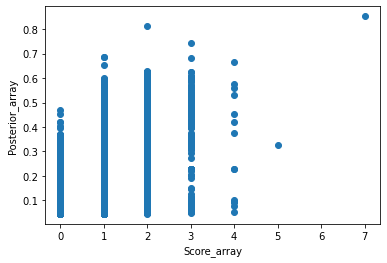

In [12]:
plt.scatter(score_array, posterior_array, s=None)
plt.xlabel('Score_array')
plt.ylabel('Posterior_array')

# Reading data

In [13]:
# First append all
print("Collecting data")
data_list = []
b_rank_list = []
y_rank_list = []
for rank, cluster in enumerate(b_sorted_clusters):
    target_tuple = (rank, cluster.seq)
    b_rank_list.append(target_tuple)
for rank, cluster in enumerate(y_sorted_clusters):
    target_tuple = (rank, cluster.seq)
    y_rank_list.append(target_tuple)
# with open("Data.txt", 'r') as data:
#     for line in data:
#         A = line.rstrip().split('\t')
#         score = A[0]
#         posterior = A[1]
#         bscore = A[2]
#         target_tuple = (score, posterior, bscore)
#         data_list.append(target_tuple)
print("Done")

Done


# Rank by count vs Rank by posterior probability

In [14]:
rank_by_count = []
rank_by_post_prob = []

b_sorted_clusters = sorted(b_cluster_array, key=operator.attrgetter('post_prob', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_cluster_array, key=operator.attrgetter('post_prob', 'pid', 'prior'), reverse = True)

score_b_sorted_clusters = sorted(b_cluster_array, key=operator.attrgetter('score', 'pid', 'prior'), reverse = True)
score_y_sorted_clusters = sorted(y_cluster_array, key=operator.attrgetter('score', 'pid', 'prior'), reverse = True)

for i, cluster in enumerate(b_sorted_clusters):
    rank_by_post_prob.append(i)
    for j, cluster2 in enumerate(score_b_sorted_clusters):
        if cluster2.seq == cluster.seq:
            rank_by_count.append(j)
            break
for i, cluster in enumerate(y_sorted_clusters):
    rank_by_post_prob.append(i)
    for j, cluster2 in enumerate(score_y_sorted_clusters):
        if cluster2.seq == cluster.seq:
            rank_by_count.append(j)
            break


Text(0, 0.5, 'Rank by posterior probability')

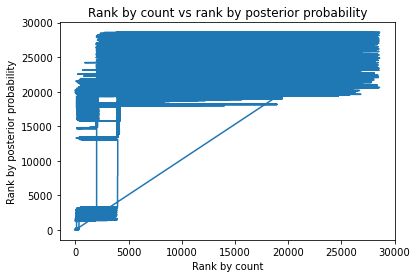

In [15]:
plt.plot(rank_by_count, rank_by_post_prob)
plt.title('Rank by count vs rank by posterior probability')
plt.xlabel('Rank by count')
plt.ylabel('Rank by posterior probability')

# To Filter data by parent prot

I want to be able to only view the b or y hits from a certain protein

In [16]:
# b_hits
target_pid = 274
b_target_clusters = []
for cluster in b_sorted_clusters:
    if cluster.pid == target_pid:
        b_target_clusters.append(cluster)

for cluster in b_target_clusters:
    non_indices = str(cluster.score) + '\t' + str(cluster.prob) + '\t' + str(cluster.pid) + '\t' + cluster.seq
    print(non_indices + '\t'+ '\t'.join([str(o) for o in cluster.indices]))


AttributeError: 'cluster' object has no attribute 'prob'

In [ ]:
# y_hits
target_pid = 274
y_target_clusters = []
for cluster in y_sorted_clusters:
    if cluster.pid == target_pid:
        y_target_clusters.append(cluster)

for cluster in y_target_clusters:
    non_indices = str(cluster.score) + '\t' + str(cluster.prob) + '\t' + str(cluster.pid) + '\t' + cluster.seq
    print(non_indices + '\t'+ '\t'.join([str(o) for o in cluster.indices]))

# See what non-hybrid solutions we can create

In [13]:
# b side starting. Ideally, we would probably pick the higher scoring side to start
filtered_b, filtered_y = testing_utils.get_top_X(b_sorted_clusters, y_sorted_clusters, 50)

# Calculating start and end indices for each interval
for b_cluster in filtered_b:
    interesting_combos = []
    b_index_set = set()
    for index in b_cluster.indices:
        index = index.replace('(', '')
        index = index.replace(')', '')
        A = index.rstrip().split(',')
        b_index_set.add(int(A[0]))
        b_index_set.add(int(A[1]))
    
    b_start_pos = min(b_index_set)
    b_end_pos = max(b_index_set)
    
    for y_cluster in filtered_y:
        y_index_set = set()
        for index in y_cluster.indices:
            index = index.replace('(', '')
            index = index.replace(')', '')
            A = index.rstrip().split(',')
            y_index_set.add(int(A[0]))
            y_index_set.add(int(A[1]))
            
        y_start_pos = min(y_index_set)
        y_end_pos = max(y_index_set)
        
        if (b_start_pos <= y_start_pos) and (b_end_pos == y_start_pos - 1):
            interesting_combos.append(b_cluster)
            interesting_combos.append(y_cluster)
    
    print(interesting_combos)

AttributeError: 'int' object has no attribute 'indices'